# Detecting Fake News in Tweets

## Table of Contents

- <a href = #Imports> Imports </a>
- <a href = #DataExploration>  Data Exploration & Feature Engineering</a>
     - <a href = #NumericData>  Numeric Data  </a>
         - <a href = #Scaling> Scaling </a>
         - <a href = #FrequencyComparrisons>  Frequency Comparrisons </a> 
     - <a href = #TextualData>  Textual Data  </a>
        - <a href = #UserDescription> User Description/ Text Body Length</a>
        - <a href = #Vocab>  Vocab </a>
        - <a href = #Hashtags>  Hashtags  </a>
        - <a href = #UserMentions> User Mentions </a>
        - <a href = #Punctuation> Punctuation Analysis </a>
        - <a href = #Retweet>Retweets </a>
        - <a href = #URLs> URLs </a>
            - <a href = #URLAnalysis> URL Analysis </a>
        - <a href = #Dates> Dates </a>
- <a href = #TextPreprocessing> Text Preprocessing </a>
- <a href = #FeatureSelection> Feature Selection </a>
    - <a href = #Upsampling> Upsampling </a>
    - <a href = #Chi-Square> Chi-Square </a>
    - <a href = #PCA> PCA </a>
- <a href = #ModelSelection> Model Selection </a>
    -  <a href = #MLP> MLP </a>
        -  <a href = #Keras> Keras </a>
        -  <a href = #Sci-kitLearn> Sci-kit Learn </a>
    -  <a href = #SVM> SVM </a>
    -  <a href = #DecisionTree> Decision Tree </a>
    - <a href = #RandomForest>  Random forest </a>
- <a href = #Hyperparameter> Hyperparameter tuning w/ GridSearch </a>
    - <a href = #SVM2> SVM </a>
    - <a href = #MLP2> MLP </a>
- <a href = #FalsePositive> False positive/ negative analysis </a>

<a name='Imports' /> 

## Library and Data Imports

In [2]:
#imports
import keras
import pandas as pd
import seaborn as sns
import numpy as np
import re
import spacy
import nltk
import requests
import string
import pickle
import matplotlib.pyplot as plt 

from datetime import datetime
from dateutil import parser
from scipy import stats
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from collections import Counter
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from wordcloud import WordCloud, STOPWORDS 
from sklearn.preprocessing import MinMaxScaler
from IPython.display import clear_output


pd.options.mode.chained_assignment = None  # default='warn'
stopwords = STOP_WORDS
nlp = spacy.load('en')
text_parser = English()
nltk.download('words')
words = set(nltk.corpus.words.words())
punctuations = string.punctuation

Using TensorFlow backend.
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Dev\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [3]:
data_raw_1 = pd.read_csv("training.csv")
data_raw_2 = pd.read_csv("training_2.csv")
data_raw_3= pd.read_csv("training_1.csv")
data_raw = pd.concat([data_raw_1,data_raw_3,data_raw_2])
data_raw = data_raw.reset_index()
print(len(data_raw))
data_raw.head()

29738


index             tweet_id       user_name  \
0      0  1101696443813908480   davepowersNYC   
1      1  1180294427958501376    Katty_Kissem   
2      2  1132742625864441861    maehamilton1   
3      3  1134120895365169152       slothy420   
4      4  1120864570896261121  RestlessWestie   

                              user_profile_image_url  user_account_create  \
0  https://pbs.twimg.com/profile_images/260903910...  2009-06-13 04:03:15   
1  https://pbs.twimg.com/profile_images/776434970...  2016-09-15 14:04:46   
2  https://abs.twimg.com/sticky/default_profile_i...  2011-07-02 17:22:32   
3  https://pbs.twimg.com/profile_images/787657262...  2010-05-05 14:42:54   
4  https://pbs.twimg.com/profile_images/122943245...  2016-12-12 17:12:18   

                 user_url                                   user_description  \
0  http://t.co/nEzLRUEdbV                                          Kindness.   
1                     NaN  also @KattyKissem #TrumpIsANationalSecurityThr...   
2                     NaN  Mother, grandmother.  I have two wonderful gra...   
3                     NaN      Opinions are my own.\nRT do not = endorsement   
4                     NaN  Dem Socialist, animal lover, artist 👉 Bernie 2...   

  user_verified user_protected user_followers_count  ... Tweet_language  \
0         False          False                  827  ...             en   
1         False          False                  568  ...             en   
2         False          False                 1887  ...             en   
3         False          False                 1202  ...             en   
4         False          False                 4089  ...             en   

  Tweet_coordinates     Tweet_created_at         Tweet_source Tweet_favorited  \
0           (None,)  2019-03-02 04:11:15   Twitter Web Client           False   
1           (None,)  2019-10-05 01:31:35   Twitter for iPhone           False   
2           (None,)  2019-05-26 20:17:42   Twitter Web Client           False   
3           (None,)  2019-05-30 15:34:27  Twitter for Android           False   
4           (None,)  2019-04-24 01:38:33  Twitter for Android           False   

  Tweet_reply_to_status Tweet_reply_to_user Tweet_retweets Tweet_favorites  \
0                   NaN                 NaN         1920.0             0.0   
1                   NaN                 NaN         6528.0             0.0   
2                   NaN                 NaN            1.0             0.0   
3                   NaN                 NaN         2558.0             0.0   
4                   NaN                 NaN            2.0             0.0   

  label  
0   0.0  
1   1.0  
2   0.0  
3   0.0  
4   0.0  

[5 rows x 32 columns]

In [668]:
data_raw.to_csv("training_full.csv")

<a name='DataExploration' />

## Data Exploration & Feature Engineering

### Class imbalance

In [3]:
data_raw["label"].value_counts()

0.0    20140
1.0     9588
Name: label, dtype: int64

In [4]:
data_raw["label"].mean()

0.322524219590958

We can't look at correlations using the label mean until the dataset is balanced, as there are far more "real information" tweets that skew the mean towards 0

<br>Null value vizualisation

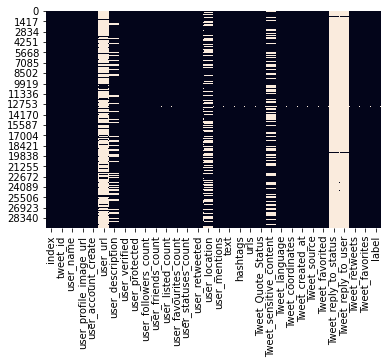

In [5]:
sns.heatmap(data_raw.isnull(), cbar=False)

### Retweeted

In [6]:
data_raw["user_retweeted"].value_counts()

False                                                                                                                                       19824
False                                                                                                                                        9906
0                                                                                                                                               2
https://www.breitbart.com/politics/2019/02/10/number-of-anchor-babies-in-10-states-more-than-4x-boston-population/                              1
https://www.breitbart.com/tech/2019/06/24/project-veritas-google-exec-decries-trumps-election-how-do-we-prevent-it-from-happening-again/        1
https://www.theblaze.com/facebook-suspends-candace-owens                                                                                        1
Name: user_retweeted, dtype: int64

### Quote status

In [7]:
data_raw["Tweet_Quote_Status"].value_counts()

False                  17725
False                   8844
True                    2099
True                    1060
Twitter for Android        3
Name: Tweet_Quote_Status, dtype: int64

### Sensitive content

In [8]:
data_raw["Tweet_sensitive_content"].value_counts()

False    19521
True       479
Name: Tweet_sensitive_content, dtype: int64

### Favorited Tweet

In [9]:
data_raw["Tweet_favorited"].value_counts()

False    19824
False     9904
0            3
Name: Tweet_favorited, dtype: int64

### Verified User

In [10]:
data_raw["user_verified"].value_counts()

False      19650
False       9815
True         174
True          91
52575          2
(None,)        2
263033         1
Name: user_verified, dtype: int64

### Sensitive Tweet

In [11]:
data_raw["Tweet_sensitive_content"].value_counts()

False    19521
True       479
Name: Tweet_sensitive_content, dtype: int64

## Initial feature selection

### All features we want to use

In [4]:
data_raw_features = data_raw[["user_name","user_account_create","user_description","user_verified","user_followers_count","user_friends_count","user_listed_count","user_favourites_count","user_statuses_count","user_location","text","hashtags","urls","Tweet_Quote_Status","Tweet_sensitive_content",
                              "Tweet_created_at","Tweet_retweets","label"]]

### Numeric features

In [5]:
data_raw_numeric = data_raw_features[["user_followers_count","user_friends_count","user_listed_count","user_favourites_count","user_statuses_count","Tweet_retweets","label"]]

### Text features

In [6]:
data_raw_text = data_raw[["user_name","user_account_create","user_description","text","hashtags","label"]]

<a name='NumericData' />

## Numeric Feautre Exploration

In [7]:
data_raw_numeric.head()

user_followers_count user_friends_count user_listed_count  \
0                  827                170               144   
1                  568               1057                12   
2                 1887               1691               114   
3                 1202               1887                 3   
4                 4089               4075                 2   

  user_favourites_count user_statuses_count  Tweet_retweets  label  
0                     7              200375          1920.0    0.0  
1                 41733               33941          6528.0    1.0  
2                247238              297423             1.0    0.0  
3                 93995               67095          2558.0    0.0  
4                 59771               16470             2.0    0.0

In [8]:
data_raw_numeric.dtypes

user_followers_count      object
user_friends_count        object
user_listed_count         object
user_favourites_count     object
user_statuses_count       object
Tweet_retweets           float64
label                    float64
dtype: object

In [9]:
data_raw_numeric = data_raw_numeric.apply(pd.to_numeric, errors='coerce')

In [10]:
data_raw_numeric.median()

user_followers_count      1148.0
user_friends_count        1467.0
user_listed_count            5.0
user_favourites_count    36682.5
user_statuses_count      43246.0
Tweet_retweets             428.0
label                        0.0
dtype: float64

In [11]:
data_raw_numeric.mean()

user_followers_count      9879.146855
user_friends_count        4709.393374
user_listed_count           64.595560
user_favourites_count    67603.043391
user_statuses_count      80337.168741
Tweet_retweets            1610.899018
label                        0.322524
dtype: float64

In [12]:
data_raw_numeric.isna().sum()

user_followers_count      8
user_friends_count        8
user_listed_count         8
user_favourites_count     8
user_statuses_count       6
Tweet_retweets           10
label                    10
dtype: int64

Fill missing values with medians - except label (drop those)

In [13]:
data_raw_numeric = data_raw_numeric[data_raw_numeric['label'].notna()]
data_raw_numeric.reset_index(inplace=True)

In [14]:
#drop the new index column
data_raw_numeric = data_raw_numeric.drop("index", 1)

In [15]:
len(data_raw_numeric)

29728

In [16]:
data_raw_numeric = data_raw_numeric.fillna(data_raw_numeric.median())

In [17]:
data_raw_numeric.isna().sum()

user_followers_count     0
user_friends_count       0
user_listed_count        0
user_favourites_count    0
user_statuses_count      0
Tweet_retweets           0
label                    0
dtype: int64

In [18]:
data_raw_numeric.max()

user_followers_count     45251322.0
user_friends_count         446970.0
user_listed_count          203424.0
user_favourites_count     1327797.0
user_statuses_count       2471837.0
Tweet_retweets              37936.0
label                           1.0
dtype: float64

In [19]:
data_raw_numeric.min()

user_followers_count     0.0
user_friends_count       0.0
user_listed_count        0.0
user_favourites_count    0.0
user_statuses_count      1.0
Tweet_retweets           0.0
label                    0.0
dtype: float64

In [20]:
data_raw_numeric.median()

user_followers_count      1148.0
user_friends_count        1467.0
user_listed_count            5.0
user_favourites_count    36686.0
user_statuses_count      43251.5
Tweet_retweets             428.0
label                        0.0
dtype: float64

In [23]:
data_raw_numeric.mean()

user_followers_count      9879.810280
user_friends_count        4709.710206
user_listed_count           64.599906
user_favourites_count    67607.591496
user_statuses_count      80346.630449
Tweet_retweets            1610.899018
label                        0.322524
dtype: float64

In [24]:
data_raw_numeric.describe()

user_followers_count  user_friends_count  user_listed_count  \
count          2.972800e+04        29728.000000       29728.000000   
mean           9.879810e+03         4709.710206          64.599906   
std            3.835297e+05        10787.964981        1730.132475   
min            0.000000e+00            0.000000           0.000000   
25%            2.580000e+02          411.000000           1.000000   
50%            1.148000e+03         1467.000000           5.000000   
75%            4.124000e+03         4894.000000          23.000000   
max            4.525132e+07       446970.000000      203424.000000   

       user_favourites_count  user_statuses_count  Tweet_retweets  \
count           2.972800e+04         2.972800e+04    29728.000000   
mean            6.760759e+04         8.034663e+04     1610.899018   
std             9.024762e+04         1.135606e+05     2515.806442   
min             0.000000e+00         1.000000e+00        0.000000   
25%             1.128275e+04         1.474500e+04       48.000000   
50%             3.668600e+04         4.325150e+04      428.000000   
75%             8.737225e+04         1.008788e+05     2371.000000   
max             1.327797e+06         2.471837e+06    37936.000000   

              label  
count  29728.000000  
mean       0.322524  
std        0.467450  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        1.000000  
max        1.000000

In [25]:
data_raw_numeric.corr()

user_followers_count  user_friends_count  \
user_followers_count               1.000000            0.033643   
user_friends_count                 0.033643            1.000000   
user_listed_count                  0.984259            0.035581   
user_favourites_count              0.001459            0.214809   
user_statuses_count                0.033343            0.312847   
Tweet_retweets                    -0.005905           -0.081665   
label                              0.012264           -0.026050   

                       user_listed_count  user_favourites_count  \
user_followers_count            0.984259               0.001459   
user_friends_count              0.035581               0.214809   
user_listed_count               1.000000               0.003025   
user_favourites_count           0.003025               1.000000   
user_statuses_count             0.056174               0.546647   
Tweet_retweets                 -0.007288               0.003963   
label                           0.018802               0.048593   

                       user_statuses_count  Tweet_retweets     label  
user_followers_count              0.033343       -0.005905  0.012264  
user_friends_count                0.312847       -0.081665 -0.026050  
user_listed_count                 0.056174       -0.007288  0.018802  
user_favourites_count             0.546647        0.003963  0.048593  
user_statuses_count               1.000000       -0.057670  0.012736  
Tweet_retweets                   -0.057670        1.000000  0.198775  
label                             0.012736        0.198775  1.000000

In [26]:
sns.pairplot(data_raw_numeric)

<a name='Scaling' />

### Scaling

This might be easier to understand if we scaled the data

In [21]:
data_raw_numeric_logged = np.log2(data_raw_numeric.loc
                                        [:, data_raw_numeric.columns != "label"]
                                        .replace(0, np.nan))

In [22]:
data_raw_numeric_logged = data_raw_numeric_logged.fillna(0)

In [23]:
data_raw_numeric_logged["label"] = data_raw_numeric["label"]

In [24]:
data_raw_numeric_logged.head()

user_followers_count  user_friends_count  user_listed_count  \
0              9.691744            7.409391           7.169925   
1              9.149747           10.045760           3.584963   
2             10.881879           10.723661           6.832890   
3             10.231221           10.881879           1.584963   
4             11.997532           11.992584           1.000000   

   user_favourites_count  user_statuses_count  Tweet_retweets  label  
0               2.807355            17.612343       10.906891    0.0  
1              15.348901            15.050741       12.672425    1.0  
2              17.915541            18.182157        0.000000    0.0  
3              16.520296            16.033918       11.320801    0.0  
4              15.867158            14.007553        1.000000    0.0

In [31]:
sns.pairplot(data_raw_numeric_logged)

In [32]:
data_raw_numeric_logged.head()

user_followers_count  user_friends_count  user_listed_count  \
0              9.691744            7.409391           7.169925   
1              9.149747           10.045760           3.584963   
2             10.881879           10.723661           6.832890   
3             10.231221           10.881879           1.584963   
4             11.997532           11.992584           1.000000   

   user_favourites_count  user_statuses_count  Tweet_retweets  label  
0               2.807355            17.612343       10.906891    0.0  
1              15.348901            15.050741       12.672425    1.0  
2              17.915541            18.182157        0.000000    0.0  
3              16.520296            16.033918       11.320801    0.0  
4              15.867158            14.007553        1.000000    0.0

Upsample smaller class before doing frequency based comparrisons:

In [25]:
misinformation = data_raw_numeric_logged[data_raw_numeric_logged["label"]==1]
realinformation = data_raw_numeric_logged[data_raw_numeric_logged["label"]==0]
print(len(misinformation), len(realinformation))

9588 20140


In [26]:
# upsample minority
misinformation = resample(misinformation,
                              replace=True, # sample with replacement
                              n_samples=len(realinformation), # match number in majority class
                              random_state=1) # reproducible results

In [27]:
print(len(misinformation), len(realinformation))

20140 20140


<a name='FrequencyComparrisons' />

### Frequency comparrisons

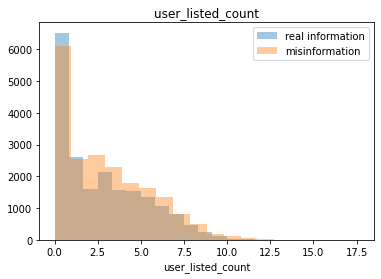

In [36]:
for col in data_raw_numeric.columns[1:-1]:
    
    fig, axes = plt.subplots(nrows=1, ncols=1)
    ax = sns.distplot( realinformation[col] , label = 'real information', bins=18,  kde =False)
    ax = sns.distplot( misinformation[col] , label = 'misinformation', bins=18, kde =False)
    ax.legend()
    _=ax.set_title(col)
    
    

There doesnt seem to be that much correlation between frequencies of certain values and whether they are real information or not!

In [167]:
scaler = MinMaxScaler()
data_raw_numeric_logged_scaled = pd.DataFrame(scaler.fit_transform(data_raw_numeric_logged), 
                                              columns = data_raw_numeric_logged.columns)

In [168]:
data_raw_numeric_logged_scaled.head()

user_followers_count  user_friends_count  user_listed_count  \
0              0.381093            0.394750           0.406594   
1              0.359781            0.535208           0.203297   
2              0.427891            0.571325           0.387481   
3              0.402306            0.579754           0.089880   
4              0.471760            0.638929           0.056708   

   user_favourites_count  user_statuses_count  Tweet_retweets  label  
0               0.138017             0.829318        0.717026    0.0  
1               0.754594             0.708699        0.833094    1.0  
2               0.880777             0.856149        0.000000    0.0  
3               0.812183             0.754994        0.744237    0.0  
4               0.780073             0.659578        0.065741    0.0

We've got our numerical data ready to be consumed by a model, now lets look at the textual data

<a name='TextualData' />


## Text Feature Exploration

In [45]:
data_raw_text.head(3)

user_name  user_account_create  \
0  davepowersNYC  2009-06-13 04:03:15   
1   Katty_Kissem  2016-09-15 14:04:46   
2   maehamilton1  2011-07-02 17:22:32   

                                    user_description  \
0                                          Kindness.   
1  also @KattyKissem #TrumpIsANationalSecurityThr...   
2  Mother, grandmother.  I have two wonderful gra...   

                                                text hashtags  label  
0  RT @TheOnion: Trump Administration Denies Pres...       []    0.0  
1  RT @kylegriffin1: Breaking via NYT: A second i...       []    1.0  
2  RT @khankiso: Corrupt Foreign Donor Who Gives ...       []    0.0

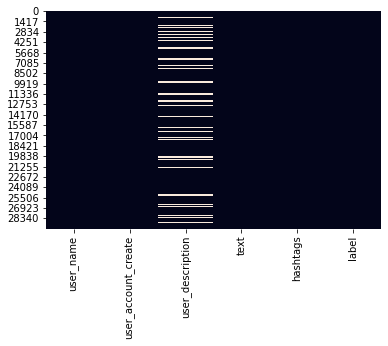

In [46]:
sns.heatmap(data_raw_text.isnull(), cbar=False)

In [47]:
data_raw_text.isna().sum()

user_name                 0
user_account_create       0
user_description       5165
text                      5
hashtags                  7
label                    10
dtype: int64

### User name

In [48]:
data_raw_text["user_name"].value_counts()

AIIAmericanGirI    26
ReciteSocial       18
CcriderJohn        12
absrdNEWS          12
4NuNuSummer03      11
                   ..
sandras09418083     1
born_summer62       1
OlaGronlund         1
FischerBuc          1
READY2MIX           1
Name: user_name, Length: 22893, dtype: int64

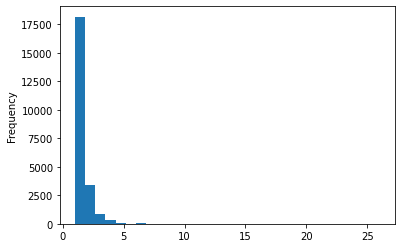

In [49]:
data_raw_text['user_name'].value_counts().plot(
    kind='hist',
    bins=30,
    )

How many exactly are unique?

In [50]:
len(set(np.asarray(data_raw_text["user_name"]))) 

22893

The vast majority of username are unique so this wont be a helpful feature for our classification

<a name='UserDescription' />

### User Descriptions and Tweet Body

Lets look at the user descriptions and the text body

In [29]:
texts = [i for i in data_raw_features.text]

In [30]:
data_raw_text["length"] = [len(str(i)) for i in texts]

In [31]:
data_raw_text["word_count"] = [len(str(i).split()) for i in texts ]

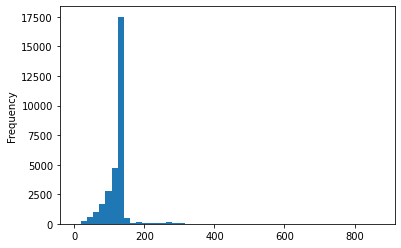

In [32]:
data_raw_text['length'].plot(
    kind='hist',
    bins=50,
    )

In [33]:
data_raw_text['word_count'].plot(
    kind='hist',
    bins=50,
    )

Looks like API limiations means we can only scrape the first 140 characters from many tweets

In [34]:
len(data_raw_text[data_raw_text.length>140]["text"])

1220

There's only 1220 text bodys longer than 140 characters

<a name='Vocab' />

### Vocab Analysis

Lets have a look at the text body

In [35]:
#vocab exploration
def get_vocab(lst):
    vocabcount = Counter(w for txt in lst for w in txt.split())
    vocab = list(map(lambda x: x[0], sorted(vocabcount.items(), key=lambda x: -x[1])))
    return vocab, vocabcount

In [36]:
texts = data_raw_text["text"].astype(str)

In [37]:
voc, cou = get_vocab(texts)

In [38]:
("TOP 10: ",[(v, cou[v]) for v in voc][:50])

('TOP 10: ',
 [('RT', 26436),
  ('to', 9673),
  ('the', 9425),
  ('a', 5773),
  ('of', 5260),
  ('@TheOnion:', 4567),
  ('in', 4113),
  ('and', 4088),
  ('Trump', 3816),
  ('is', 3129),
  ('for', 3033),
  ('To', 2757),
  ('The', 2731),
  ('on', 2504),
  ('with', 2388),
  ('by', 2317),
  ('that', 2111),
  ('Of', 2060),
  ('this', 1560),
  ('has', 1554),
  ('In', 1548),
  ('not', 1526),
  ('from', 1452),
  ('I', 1389),
  ('are', 1378),
  ('you', 1349),
  ('was', 1273),
  ('at', 1268),
  ('@marklevinshow:', 1143),
  ('our', 1128),
  ('|', 1083),
  ('@RealJamesWoods:', 1079),
  ('have', 1073),
  ('Is', 1060),
  ('Illegal', 1058),
  ('his', 1036),
  ('Ukraine', 970),
  ('-', 930),
  ('it', 929),
  ('By', 915),
  ('via', 899),
  ('This', 898),
  ('U.S.', 874),
  ('@AnnCoulter:', 873),
  ('who', 871),
  ('an', 870),
  ('Brought', 863),
  ('he', 835),
  ('If', 832),
  ('News', 819)])

There seems to be a lot of stop words, user mentions and hashtags. <br>
Let's have another look at the vocab without any of these things

In [39]:
def process_for_vocab_analysis(column, label=""):
    tick = datetime.now()

    df = data_raw_text
    
    if label:
        
        df = data_raw_text[data_raw_text["label"]==label]
        
    stg = []
    for i,doc in enumerate(df[column].astype(str)):

        mytokens_feature = text_parser(doc)
        mytokens_feature = np.asarray([ word.lower_.strip() for word in mytokens_feature 
                               if word.lower_ not in stopwords 
                                and word.lower_ not in punctuations
                                    and word.lower_[0] != "@" 
                                        and word.lower_[0] != "#"
                                           and word.lower_[0:2] != "rt"
                                            and word.lower_[0:6]!="https:"])
        mytokens_feature = np.asarray(mytokens_feature)
        feature = re.sub(r'\W+', ' ', " ".join(mytokens_feature) )
        
        feature= " ".join([w for w in feature.split()
                             if len(w) > 1])
        
        stg.append(feature)


    #remove non english
    stg2=[]
    for i,sent in enumerate(stg):
        " ".join(w for w in nltk.wordpunct_tokenize(sent) if w in words)

        stg2.append(sent)
    
    tock = datetime.now()    
    print("time taken: ",tock - tick) 
    
    return stg2
    

In [40]:
stg2 = process_for_vocab_analysis("text")

time taken:  0:00:30.306515


In [41]:
stg3 = process_for_vocab_analysis("user_description")

time taken:  0:00:29.280163


Text body analysis

In [42]:
tb_df = pd.DataFrame(sorted( dict(Counter(w for txt in stg2 for w in txt.split())).items(), 
                            key= lambda x: -x[1]    ) ,columns=["word","frequency"] )
tb_df.head(30)

word  frequency
0           trump       5427
1         ukraine       1269
2            news       1253
3         illegal       1218
4             gun       1216
5       president       1201
6         brought       1159
7             new       1155
8            says        967
9        american        948
10     california        930
11          house        797
12           like        758
13         search        748
14          media        731
15           time        730
16       security        720
17      breitbart        703
18         google        689
19         border        686
20          biden        677
21          child        670
22           visa        647
23           miss        640
24  whistleblower        634
25           fake        630
26          alien        630
27            cnn        624
28           real        624
29        charged        619

In [43]:
tb_df['frequency'].head(100).plot(
    )

User description analysis

In [44]:
ud_df = pd.DataFrame(sorted( dict(Counter(w for txt in stg3 for w in txt.split())).items(), 
                            key= lambda x: -x[1]    ) ,columns=["word","frequency"] )
ud_df.head(30)

word  frequency
0           maga       5360
1            nan       5166
2          trump       3659
3           love       2528
4   conservative       2223
5            kag       2206
6            god       1976
7          proud       1502
8      christian       1388
9        country       1377
10          life       1297
11     trump2020       1245
12            2a       1232
13     president       1228
14       patriot       1177
15        family       1159
16      american       1147
17       wwg1wga       1132
18       america       1098
19       retired       1071
20       married       1050
21           nra       1043
22           pro       1031
23           mom        993
24          wife        975
25     supporter        877
26        resist        859
27           fan        787
28         lover        765
29        mother        747

In [45]:
ud_df['frequency'].head(100).plot(
    )

Lets have a look if there is any difference between vocab in each class

Before doing direct comparrisons let's downsample the majority class:

In [46]:
misinformation = data_raw_text[data_raw_text["label"]==1]
realinformation = data_raw_text[data_raw_text["label"]==0]
print(len(misinformation), len(realinformation))
# downsample majority
realinformation = resample(realinformation,
                              replace=True, # sample with replacement
                              n_samples=len(misinformation), # match number in majority class
                              random_state=1) # reproducible results

print(len(misinformation), len(realinformation))

9588 20140
9588 9588


Mis information:

In [47]:
tick = datetime.now()

column= "text"
df = misinformation

stg = []
for i,doc in enumerate(df[column].astype(str)):

    mytokens_feature = text_parser(doc)
    mytokens_feature = np.asarray([ word.lower_.strip() for word in mytokens_feature 
                           if word.lower_ not in stopwords 
                            and word.lower_ not in punctuations
                                and word.lower_[0] != "@" 
                                    and word.lower_[0] != "#"
                                       and word.lower_[0:2] != "rt"
                                        and word.lower_[0:6]!="https:"])
    mytokens_feature = np.asarray(mytokens_feature)
    feature = re.sub(r'\W+', ' ', " ".join(mytokens_feature) )

    feature= " ".join([w for w in feature.split()
                         if len(w) > 1])

    stg.append(feature)


#remove non english
stg2=[]
for i,sent in enumerate(stg):
    " ".join(w for w in nltk.wordpunct_tokenize(sent) if w in words)

    stg2.append(sent)

tock = datetime.now()    
print("time taken: ",tock - tick)     

time taken:  0:00:12.177944


In [48]:
stg2[0]

'breaking nyt second intel official alarmed trump ukraine dealings weighing file'

In [49]:
misinfo_vocab = pd.DataFrame(sorted( dict(Counter(w for txt in stg2 for w in txt.split())).items(), 
                            key= lambda x: -x[1]    ) ,columns=["word","frequency"] )
misinfo_vocab.head(10)

word  frequency
0          trump       3401
1        ukraine       1269
2      president        772
3          house        671
4          biden        614
5           news        607
6  whistleblower        607
7            new        573
8           says        478
9    impeachment        447

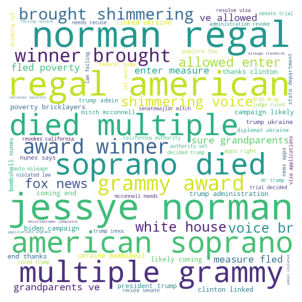

In [50]:
words = ""

for i in stg2:
    
    for j in i.split():
    
        words += " " + j
    

            
stopwords = set(STOPWORDS) 

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(words)
plt.figure(figsize = (4, 4), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

Real information:

In [51]:
tick = datetime.now()

column= "text"
df = realinformation

stg = []
for i,doc in enumerate(df[column].astype(str)):

    mytokens_feature = text_parser(doc)
    mytokens_feature = np.asarray([ word.lower_.strip() for word in mytokens_feature 
                           if word.lower_ not in stopwords 
                            and word.lower_ not in punctuations
                                and word.lower_[0] != "@" 
                                    and word.lower_[0] != "#"
                                       and word.lower_[0:2] != "rt"
                                        and word.lower_[0:6]!="https:"])
    mytokens_feature = np.asarray(mytokens_feature)
    feature = re.sub(r'\W+', ' ', " ".join(mytokens_feature) )

    feature= " ".join([w for w in feature.split()
                         if len(w) > 1])

    stg.append(feature)


#remove non english
stg3=[]
for i,sent in enumerate(stg):
    " ".join(w for w in nltk.wordpunct_tokenize(sent) if w in words)

    stg3.append(sent)

tock = datetime.now()    
print("time taken: ",tock - tick)     

time taken:  0:00:26.764461


In [52]:
realinfo_vocab = pd.DataFrame(sorted( dict(Counter(w for txt in stg3 for w in txt.split())).items(), 
                            key= lambda x: -x[1]    ) ,columns=["word","frequency"] )
realinfo_vocab.head(10)

word  frequency
0       trump        998
1     illegal        558
2         gun        537
3        will        419
4     brought        398
5         one        381
6  california        373
7       alien        344
8      search        339
9         via        327

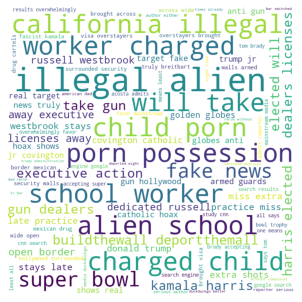

In [53]:
words = ""

for i in stg3:
    
    for j in i.split():
    
        words += " " + j
    

            
stopwords = set(STOPWORDS) 

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(words)
plt.figure(figsize = (4, 4), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

Lets do some vocab comparrisons between the two classes

In [54]:
realinfo_vocab.head()

word  frequency
0    trump        998
1  illegal        558
2      gun        537
3     will        419
4  brought        398

In [55]:
misinfo_vocab.head()

word  frequency
0      trump       3401
1    ukraine       1269
2  president        772
3      house        671
4      biden        614

In [56]:
#word freq dicts
misinfo_freq = {}
for i,word in enumerate(misinfo_vocab["word"]):   
    misinfo_freq[word] = misinfo_vocab["frequency"][i]
    

realinfo_freq = {}
for i,word in enumerate(realinfo_vocab["word"]): 
    realinfo_freq[word] = realinfo_vocab["frequency"][i]

In [57]:
#find common words

no = 100

c_words=[]

misinfo_words = list(misinfo_vocab["word"][0:no])
realinfo_words = list(realinfo_vocab["word"][0:no])

for word in misinfo_words[0:no]:
    
    if word in realinfo_words:
        
        c_words.append(word)


In [58]:
common = set(c_words)
real = set(realinfo_words)
mis = set(misinfo_words)
#find set differences
uncommon_mis = mis.difference(common)
uncommon_real = real.difference(common)

In [59]:
common_table = []

for word in list(common):
    
    common_table.append([word, realinfo_freq[word], misinfo_freq[word] ])
    
common_df = pd.DataFrame(common_table, columns = ["word","real_freq","mis_freq"])

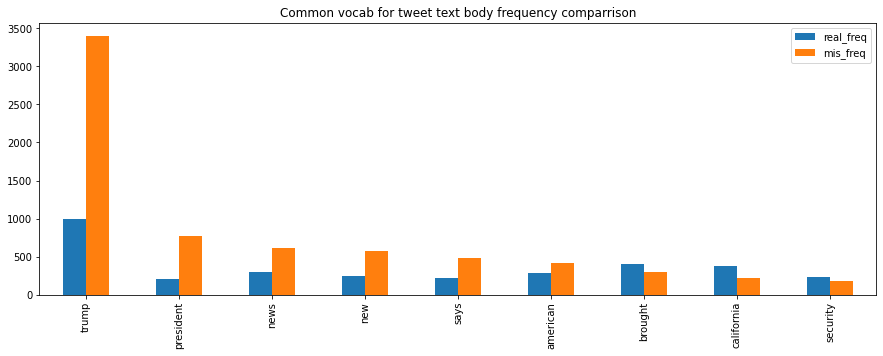

In [60]:
lent = 15
common_df_sort = common_df.sort_values(by=["mis_freq"], ascending = False).head(lent)#.sample(lent)
ax = common_df_sort.plot(title = "Common vocab for tweet text body frequency comparrison" ,kind="bar",figsize=(15,5))
_=ax.set_xticklabels(common_df_sort.word)

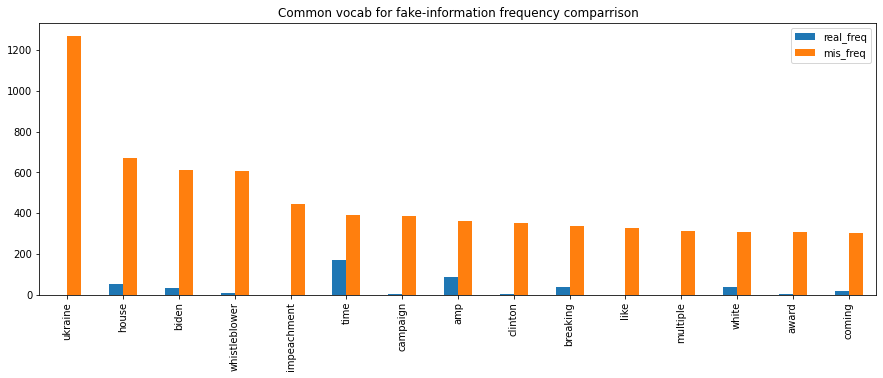

In [61]:
uncommon_mis_table = []

for word in list(uncommon_mis):
    #print(word)
    try:
        uncommon_mis_table.append([word, realinfo_freq[word], misinfo_freq[word] ])
    except:
        uncommon_mis_table.append([word, 0, misinfo_freq[word] ])
        
misinf_uncommon_df = pd.DataFrame(sorted(uncommon_mis_table, key = lambda x: -x[2]), columns = ["word","real_freq","mis_freq"]  ) 

lent = 15
misinf_uncommon_df = misinf_uncommon_df.sort_values(by=["mis_freq"], ascending = False).head(lent)#.sample(lent)
ax = misinf_uncommon_df.plot(title = "Common vocab for fake-information frequency comparrison" ,kind="bar",figsize=(15,5))
_=ax.set_xticklabels(misinf_uncommon_df.word)

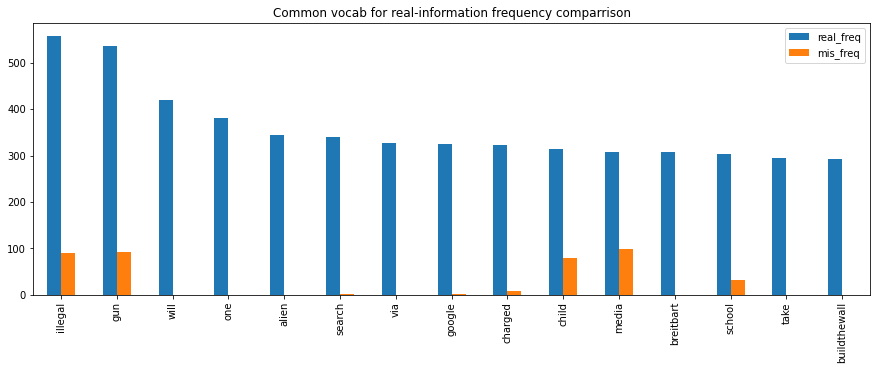

In [62]:
uncommon_real_table = []

for word in list(uncommon_real):
    #print(word)
    try:
        uncommon_real_table.append([word, realinfo_freq[word], misinfo_freq[word] ])
    except:
        uncommon_real_table.append([word, realinfo_freq[word], 0])
        
realinf_uncommon_df = pd.DataFrame(sorted(uncommon_real_table, key = lambda x: -x[2]), columns = ["word","real_freq","mis_freq"]  ) 

lent = 15
realinf_uncommon_df = realinf_uncommon_df.sort_values(by=["real_freq"], ascending = False).head(lent)#.sample(lent)
ax = realinf_uncommon_df.plot(title = "Common vocab for real-information frequency comparrison" , kind="bar",figsize=(15,5))
_=ax.set_xticklabels(realinf_uncommon_df.word)

<br>
Now let's have a look at the hashtags and user mentions that we removed

In [63]:
data_raw_text.head()

user_name  user_account_create  \
0   davepowersNYC  2009-06-13 04:03:15   
1    Katty_Kissem  2016-09-15 14:04:46   
2    maehamilton1  2011-07-02 17:22:32   
3       slothy420  2010-05-05 14:42:54   
4  RestlessWestie  2016-12-12 17:12:18   

                                    user_description  \
0                                          Kindness.   
1  also @KattyKissem #TrumpIsANationalSecurityThr...   
2  Mother, grandmother.  I have two wonderful gra...   
3      Opinions are my own.\nRT do not = endorsement   
4  Dem Socialist, animal lover, artist 👉 Bernie 2...   

                                                text  \
0  RT @TheOnion: Trump Administration Denies Pres...   
1  RT @kylegriffin1: Breaking via NYT: A second i...   
2  RT @khankiso: Corrupt Foreign Donor Who Gives ...   
3  RT @marklevinshow: Acosta admits he’s not a re...   
4  RT @NineInchBride: His War is Ours\nhttps://t....   

                                    hashtags  label  length  word_count  
0                                         []    0.0     140          16  
1                                         []    1.0     140          23  
2                                         []    0.0     134          20  
3                                         []    0.0     112          15  
4  [{'text': 'Pompeo', 'indices': [59, 66]}]    0.0     140          23

Combine user desc and text body for this analysis

In [64]:
data_raw_text["comb"] = data_raw_text["text"].astype(str) + data_raw_text["user_description"].astype(str)
texts_comb = data_raw_text["comb"]

<a name='Hashtags' />

### Hashtags

In [65]:
text_hash = []
for i in texts_comb.astype(str):
    text_hash.append(re.findall(r"#(\w+)", i))
#or
#text_hash = [re.findall(r"#(\w+)", i) for i in texts_comb.astype(str) ]

len(text_hash)

29738

In [66]:
data_raw_text["hashtags"] = text_hash

unique_hash=set()
hashs = []
for i in text_hash:
    for j in i:
        hashs.append(j)
        unique_hash.add(j)

In [67]:
hastag_df = pd.DataFrame(sorted( dict(Counter(w for txt in hashs for w in txt.split())).items(), 
                                key= lambda x: -x[1]    ) ,columns=["hashtag","frequency"] )

In [68]:
hastag_df.head(20)

hashtag  frequency
0            MAGA       3885
1             KAG       1710
2              2A        918
3    BuildTheWall        845
4         WWG1WGA        832
5       Trump2020        724
6             NRA        608
7   DeportThemAll        519
8          Resist        431
9       TRUMP2020        361
10             1A        355
11        KAG2020        329
12  TheResistance        311
13          Trump        306
14   AmericaFirst        286
15        ProLife        244
16        Patriot        228
17          QAnon        223
18            FBR        216
19   Conservative        215

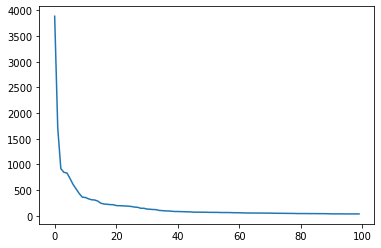

In [69]:
hastag_df['frequency'].head(100).plot(
    )

<a name='UserMentions' />

### User Mentions

In [70]:
text_users = [re.findall(r"@(\w+)", i) for i in texts_comb.astype(str) ]
len(text_users)

29738

In [71]:
unique_users=set()
users = []
for i in text_users:
    if i:  
        for j in i:
            users.append(j)
            unique_users.add(j)


In [72]:
print(len(users))
print(len(unique_users))

36492
6103


In [73]:
mentions_df = pd.DataFrame(sorted( dict(Counter(w for txt in users for w in txt.split())).items(), 
                                key= lambda x: -x[1]    ) ,columns=["user_mention","frequency"] )

In [74]:
mentions_df.head(20)

user_mention  frequency
0          TheOnion       4595
1     marklevinshow       1153
2    RealJamesWoods       1114
3        AnnCoulter        900
4      kimguilfoyle        640
5      RealSaavedra        570
6      kylegriffin1        559
7   realDonaldTrump        510
8    DonaldJTrumpJr        496
9        JxhnBinder        423
10    BreitbartNews        399
11          nytimes        381
12     PrisonPlanet        379
13       DevinNunes        348
14         GenFlynn        307
15  BreitbartLondon        285
16  FrankFigliuzzi1        279
17  LindseyGrahamSC        211
18            POTUS        199
19  secretstranger9        174

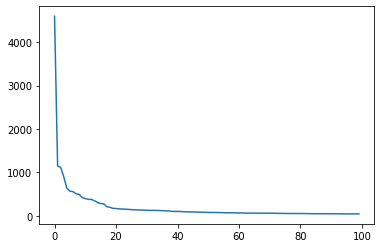

In [75]:
mentions_df['frequency'].head(100).plot()

<a name='Punctuation' />

### Punctuation Analysis

Number of exclamation marks + question marks

In [76]:
punc_marks = []

tick = datetime.now()

for text in texts:
    puncs = 0
    for char in text:
        if char == "?" or char == "!":
            puncs += 1
    punc_marks.append(puncs)
        
tock = datetime.now()    
print("time taken: ",tock - tick)         

time taken:  0:00:00.713556


In [77]:
data_raw_text["puncs"] = punc_marks

In [78]:
data_raw_text["puncs"].value_counts()[0:10]

0    25883
1     2530
2      873
3      192
4      143
5       90
6       12
9        3
8        3
7        3
Name: puncs, dtype: int64

In [79]:
data_raw_text['puncs'].plot(
    )

In [80]:
data_raw_text["puncs"].max()

73

Lets take a look at that anomolous row

In [81]:
data_raw_text[data_raw_text["puncs"]==73]

user_name  user_account_create  \
12462  d_fucile  2016-07-18 04:22:10   

                                        user_description  \
12462  I'VE GOT AN OPINION LIKE IT OR NOT! NO PORN! N...   

                                                    text     hashtags  label  \
12462  FASCISTS!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...  [MAGA, KAG]    0.0   

       length  word_count                                               comb  \
12462     141           8  FASCISTS!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...   

       puncs  
12462     73

Interesting..

<a name='Retweet' />

### Retweets

Now finally let's have a look at retweet information, we can extract this from whether a tweet starts with RT

In [82]:
def check(i):
    if str(i)[0:2]=="RT":
        return 1
    return 0

In [83]:
rt = [check(i) for i in data_raw_text["text"]]

In [84]:
pd.Series(rt).value_counts()

1    26423
0     3315
dtype: int64

In [85]:
data_raw_text["rt"] = rt

And let's analyse it in comparison to the label

In [86]:
ct = pd.crosstab(data_raw_text['rt'], data_raw_text['label'], 
                                      margins=True)
ct

label    0.0   1.0    All
rt                       
0       1969  1336   3305
1      18171  8252  26423
All    20140  9588  29728

In [87]:
misinformation = data_raw_text[data_raw_text["label"]==1]
realinformation = data_raw_text[data_raw_text["label"]==0]
print(len(misinformation), len(realinformation))
# upsample minority
misinformation = resample(misinformation,
                              replace=True, # sample with replacement
                              n_samples=len(realinformation), # match number in majority class
                              random_state=1) # reproducible results

print(len(misinformation), len(realinformation))

fig, axes = plt.subplots(nrows=1, ncols=1)
ax = sns.kdeplot( realinformation.rt , label = 'real information')
ax = sns.kdeplot( misinformation.rt , label = 'misinformation' )
ax.legend()
_=ax.set_title("Retweet")

9588 20140
20140 20140


<a name='URLs' />

### URLS in the User Descriptions and Tweet Bodys


Now lets have a look at the domains that people have been linking in their tweets and user descriptions

The domains are all re-directed from https://t.co so we'll need to first work out where they are directed to

In [101]:
domains_list=[]
for text in texts_comb:
    
    domains_t = []
    pattern=re.compile(r'https?://([A-Za-z_0-9.-]+).*')
    matches = re.finditer(pattern,text)
    
    for match in matches:
        
        link_sentence = match.group(0)
        domain = str(link_sentence).split()[0]
        domains_t.append(domain)
        
    domains_list.append(domains_t)

In [8]:
domains_list[0:10]

[['https://t.co/ZcLvOuiJYq'],
 [],
 ['https://t.co/rqaj8YaQUt'],
 ['https://t.co/ZuAAtbJWfnOpinions'],
 ['https://t.co/4lXk6ihmbn'],
 ['https://t.co/F7t4aqJo6f'],
 ['https://t.co/GRLoENVCsyAnti'],
 ['https://t.co/GRLoENVCsy#wr'],
 ['https://t.co/8jQkazBwxq.'],
 []]

In [9]:
tick = datetime.datetime.now() 

redirects = []

for i,domains in enumerate(domains_list):
    
    redirects_t = []
    
    for domain in domains:
        #some of the links are broken so we have to catch exceptions
        try:
            r = requests.get(domain[0:23])
            redirects_t.append(r.url)
        except:
            redirects_t.append(domain)
    redirects.append(redirects_t)
    
    #verbose
    if i % 100 == 0:
        clear_output(wait=True)
        print(i)
        print(redirects_t)
        
tock = datetime.datetime.now()    
print("time taken: ",tock - tick)    

29700
['https://www.breitbart.com/clips/2019/07/21/booker-trump-is-worse-than-a-racist-similar-to-george-wallace/']
time taken:  6:20:45.304658


This might take a bit less time if you have better internet than me :) 

Let's save it the result..

In [217]:
with open('redirects.pickle', 'wb') as fp:
    pickle.dump(redirects, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [88]:
with open('redirects.pickle', 'rb') as fp:
    redirects = pickle.load(fp) 

In [89]:
redirects[0:3]

[['https://politics.theonion.com/trump-administration-denies-president-was-behind-jared-1832993759?utm_content=Main&utm_campaign=SF&utm_source=Twitter&utm_medium=SocialMarketing'],
 [],
 ['https://www.politicususa.com/2019/05/26/corrupt-foreign-donor-who-gives-to-gop-gets-62-million-in-trump-trade-war-aid.html']]

<br>
Now we've got all the re-direct links we can look at the words in these links

We want to pull out the useful info in the URL

In [90]:
tick = datetime.now()

new_domains = []
new_domain_subs = []

for redirect_l in redirects:
    
    new_domain_subs_t = []
    new_domains_t = []
    
    for redirect in redirect_l:
        
        new_subs = []
        
        if redirect:
            
            t1 = redirect.split("/")
            new_domains_t.append(t1[2])
            
            #we only want to look from the domain (pos 2) to the end of the URL
            for subs in t1[3:len(t1)]:
                t2 = subs.split("-")
                 
                for word in t2:
                    new_subs.append(word)
                        
        new_domain_subs_t.append(new_subs)
    new_domains.append(new_domains_t)                
    new_domain_subs.append(new_domain_subs_t)
    
tock = datetime.now()    
print("time taken: ",tock - tick) 

time taken:  0:00:00.276989


In [91]:
#test this has worked...
t = 4

print(redirects[t])
print(new_domains[t])
print(new_domain_subs[t])

['https://21stcenturywire.com/2019/04/21/why-julian-assanges-war-is-our-war-too/']
['21stcenturywire.com']
[['2019', '04', '21', 'why', 'julian', 'assanges', 'war', 'is', 'our', 'war', 'too', '']]


In [92]:
#is it working with tweets with multiple links in...
t =149
print(redirects[t])
print(new_domains[t])
print(new_domain_subs[t])

['https://twitter.com/CounselorJeff88/status/1138582246305280000', 'https://www.amazon.com/Coal-Ice-Phil-Boiarski/dp/1480096997']
['twitter.com', 'www.amazon.com']
[['CounselorJeff88', 'status', '1138582246305280000'], ['Coal', 'Ice', 'Phil', 'Boiarski', 'dp', '1480096997']]


Looks good to me :)<br>
Now we need to add these words back into the text column so they can be used in feature extraction

In [93]:
data_raw_text.head(2)

user_name  user_account_create  \
0  davepowersNYC  2009-06-13 04:03:15   
1   Katty_Kissem  2016-09-15 14:04:46   

                                    user_description  \
0                                          Kindness.   
1  also @KattyKissem #TrumpIsANationalSecurityThr...   

                                                text  \
0  RT @TheOnion: Trump Administration Denies Pres...   
1  RT @kylegriffin1: Breaking via NYT: A second i...   

                                            hashtags  label  length  \
0                                                 []    0.0     140   
1  [TrumpIsANationalSecurityThreat, ImpeachAndRem...    1.0     140   

   word_count                                               comb  puncs  rt  
0          16  RT @TheOnion: Trump Administration Denies Pres...      0   1  
1          23  RT @kylegriffin1: Breaking via NYT: A second i...      0   1

In [94]:
texts_comb.head(2)

0    RT @TheOnion: Trump Administration Denies Pres...
1    RT @kylegriffin1: Breaking via NYT: A second i...
Name: comb, dtype: object

In [95]:
new_domains[0:3]

[['politics.theonion.com'], [], ['www.politicususa.com']]

In [96]:
new_domain_subs[0:3]

[[['trump',
   'administration',
   'denies',
   'president',
   'was',
   'behind',
   'jared',
   '1832993759?utm_content=Main&utm_campaign=SF&utm_source=Twitter&utm_medium=SocialMarketing']],
 [],
 [['2019',
   '05',
   '26',
   'corrupt',
   'foreign',
   'donor',
   'who',
   'gives',
   'to',
   'gop',
   'gets',
   '62',
   'million',
   'in',
   'trump',
   'trade',
   'war',
   'aid.html']]]

In [97]:
stg = list(texts_comb)

for i in range(len(texts_comb)):
    
    for j in new_domains[i]:
    
        stg[i] += " "+j
    
    for j in new_domain_subs[i]:
        
        for k in j:
            
            stg[i] += " "+k
    

In [98]:
#lets see if thats worked...
t = 3
print(redirects[t],"\n")
print(stg[t])

['https://www.redstate.com/alexparker/2019/05/28/finally-admits-hes-not-reporter-new-book-jim-acosta-insists-neutrality-doesnt-work-age-trump/'] 

RT @marklevinshow: Acosta admits he’s not a reporter.  He’s not a serious author either. https://t.co/ZuAAtbJWfnOpinions are my own.
RT do not = endorsement www.redstate.com alexparker 2019 05 28 finally admits hes not reporter new book jim acosta insists neutrality doesnt work age trump 


In [99]:
#lets see if thats worked...
t = 149
print(redirects[t],"\n")
print(stg[t])

['https://twitter.com/CounselorJeff88/status/1138582246305280000', 'https://www.amazon.com/Coal-Ice-Phil-Boiarski/dp/1480096997'] 

#Farmers are being #Fooled with, so to speak. https://t.co/EthYtZEnn6Internationally published poet, fictioneer, essayist, painter and twitterer. http://t.co/NdAsbq2sPH
http://t.co/ra6VH4gDh1 twitter.com www.amazon.com CounselorJeff88 status 1138582246305280000 Coal Ice Phil Boiarski dp 1480096997


In [100]:
#replace the current comb column
data_raw_text["comb"] = stg

In [101]:
data_raw_text.head()

user_name  user_account_create  \
0   davepowersNYC  2009-06-13 04:03:15   
1    Katty_Kissem  2016-09-15 14:04:46   
2    maehamilton1  2011-07-02 17:22:32   
3       slothy420  2010-05-05 14:42:54   
4  RestlessWestie  2016-12-12 17:12:18   

                                    user_description  \
0                                          Kindness.   
1  also @KattyKissem #TrumpIsANationalSecurityThr...   
2  Mother, grandmother.  I have two wonderful gra...   
3      Opinions are my own.\nRT do not = endorsement   
4  Dem Socialist, animal lover, artist 👉 Bernie 2...   

                                                text  \
0  RT @TheOnion: Trump Administration Denies Pres...   
1  RT @kylegriffin1: Breaking via NYT: A second i...   
2  RT @khankiso: Corrupt Foreign Donor Who Gives ...   
3  RT @marklevinshow: Acosta admits he’s not a re...   
4  RT @NineInchBride: His War is Ours\nhttps://t....   

                                            hashtags  label  length  \
0                                                 []    0.0     140   
1  [TrumpIsANationalSecurityThreat, ImpeachAndRem...    1.0     140   
2                                                 []    0.0     134   
3                                                 []    0.0     112   
4  [Pompeo, AcceptNoSubstitutes, MedicareForAll, ...    0.0     140   

   word_count                                               comb  puncs  rt  
0          16  RT @TheOnion: Trump Administration Denies Pres...      0   1  
1          23  RT @kylegriffin1: Breaking via NYT: A second i...      0   1  
2          20  RT @khankiso: Corrupt Foreign Donor Who Gives ...      0   1  
3          15  RT @marklevinshow: Acosta admits he’s not a re...      0   1  
4          23  RT @NineInchBride: His War is Ours\nhttps://t....      0   1

Perfect!

<a name='URLAnalysis' />

### URL Analysis

Let's do some basic vocab analysis on the words used in the urls

In [102]:
words = []

for i in range(len(redirects)):
    
    for j in new_domains[i]:
    
        words.append(j)
    
    for j in new_domain_subs[i]:
        
        for k in j:
            
            words.append(k)
    

In [103]:
len(words)

273476

In [104]:
words[0:10]

['politics.theonion.com',
 'trump',
 'administration',
 'denies',
 'president',
 'was',
 'behind',
 'jared',
 '1832993759?utm_content=Main&utm_campaign=SF&utm_source=Twitter&utm_medium=SocialMarketing',
 'www.politicususa.com']

In [105]:
d = Counter(words)

In [106]:
list({k: v for k, v in sorted(d.items(), key=lambda item: -item[1])}.items())[0:20]

[('2019', 10591),
 ('', 9354),
 ('www.breitbart.com', 7780),
 ('politics', 7138),
 ('to', 5695),
 ('of', 3953),
 ('01', 2715),
 ('trump', 2620),
 ('05', 2440),
 ('02', 2361),
 ('twitter.com', 2341),
 ('in', 2281),
 ('status', 2256),
 ('sports.theonion.com', 2086),
 ('with', 1692),
 ('06', 1675),
 ('t.co', 1585),
 ('illegal', 1573),
 ('california', 1382),
 ('the', 1337)]

In [107]:
words = ""

for i in range(len(redirects)):
    
    for j in new_domains[i]:
    
        words += " " + j
    
    for j in new_domain_subs[i]:
        
        for k in j:
            
            words += " " + k

In [108]:
len(words)

2321694

In [109]:
stopwords = set(STOPWORDS) 

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(words)
plt.figure(figsize = (4, 4), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

Now lets analyse the URLs used in real and fake information

In [110]:
len(new_domains) == len(data_raw_text) == len(new_domain_subs)

True

In [111]:
new_domains[0:10]

[['politics.theonion.com'],
 [],
 ['www.politicususa.com'],
 ['www.redstate.com'],
 ['21stcenturywire.com'],
 ['www.politicususa.com'],
 ['www.breitbart.com'],
 ['www.breitbart.com'],
 ['www.cafepress.com'],
 []]

In [112]:
new_domain_subs[0:2]

[[['trump',
   'administration',
   'denies',
   'president',
   'was',
   'behind',
   'jared',
   '1832993759?utm_content=Main&utm_campaign=SF&utm_source=Twitter&utm_medium=SocialMarketing']],
 []]

In [113]:
data_raw_text["domains"] = new_domains

In [114]:
domain_str = ""

for domain in list(data_raw_text["domains"]):

    for d in domain:
        
        domain_str += " " + d

vocab = pd.DataFrame(sorted( dict(Counter(domain_str.split())).items(), 
                            key= lambda x: -x[1]    ) ,columns=["word","frequency"] )
vocab.head(10)

word  frequency
0      www.breitbart.com       7780
1            twitter.com       2341
2    sports.theonion.com       2086
3                   t.co       1576
4       www.theonion.com       1294
5        www.foxnews.com       1291
6        edition.cnn.com        693
7       www.redstate.com        551
8  politics.theonion.com        392
9        www.nytimes.com        376

In [115]:
misinformation = data_raw_text[data_raw_text["label"]==1]
realinformation = data_raw_text[data_raw_text["label"]==0]
print(len(misinformation), len(realinformation))
# downsample majority
realinformation = resample(realinformation,
                              replace=True, # sample with replacement
                              n_samples=len(misinformation), # match number in majority class
                              random_state=1) # reproducible results

print(len(misinformation), len(realinformation))

9588 20140
9588 9588


In [116]:
#real info
domain_str = ""

for domain in list(realinformation["domains"]):

    for d in domain:
        
        domain_str += " " + d

realinfo_vocab = pd.DataFrame(sorted( dict(Counter(domain_str.split())).items(), 
                            key= lambda x: -x[1]    ) ,columns=["word","frequency"] )
realinfo_vocab.head(10)

word  frequency
0           www.breitbart.com       3721
1                 twitter.com       1079
2         sports.theonion.com        995
3            www.theonion.com        632
4                        t.co        613
5            www.redstate.com        265
6        www.politicususa.com        172
7       politics.theonion.com        169
8  entertainment.theonion.com        157
9                 www.wnd.com        150

In [117]:
#mis info
domain_str = ""

for domain in list(misinformation["domains"]):

    for d in domain:
        
        domain_str += " " + d

misinfo_vocab = pd.DataFrame(sorted( dict(Counter(domain_str.split())).items(), 
                            key= lambda x: -x[1]    ) ,columns=["word","frequency"] )
misinfo_vocab.head(10)

word  frequency
0  www.foxnews.com       1291
1  edition.cnn.com        693
2  www.nytimes.com        376
3  www.nbcnews.com        339
4             t.co        242
5   abcnews.go.com        241
6  eu.usatoday.com        105
7  www.cbsnews.com         67
8      amp.cnn.com         14
9  www.youtube.com         13

In [118]:
len(misinfo_vocab)

144

In [119]:
len(realinfo_vocab)

266

In [120]:
#word freq dicts
misinfo_freq = {}
for i,word in enumerate(misinfo_vocab["word"]):   
    misinfo_freq[word] = misinfo_vocab["frequency"][i]
    

realinfo_freq = {}
for i,word in enumerate(realinfo_vocab["word"]): 
    realinfo_freq[word] = realinfo_vocab["frequency"][i]

In [121]:
#find common words

no = 200

c_words=[]

misinfo_words = list(misinfo_vocab["word"][0:no])
realinfo_words = list(realinfo_vocab["word"][0:no])

for word in misinfo_words[0:no]:
    
    if word in realinfo_words:
        
        c_words.append(word)

#remove the useless t.. values
c_words = [word for word in c_words if word[0:2] != "t." and word[0:2] != "t…" and word[0:2] != "tw"]
misinfo_words = [word for word in misinfo_words if word[0:2] != "t." and word[0:2] != "t…" and word[0:2] != "tw"]
realinfo_words = [word for word in realinfo_words if word[0:2] != "t." and word[0:2] != "t…" and word[0:2] != "tw"]

Of the most common 200 domains, there are only 7 that appear in real and misinformation! This is an indicator that there is a heavy correlation between domain and real/misinformation.

In [122]:
len(c_words)

7

In [123]:
c_words

['www.youtube.com',
 'www.instagram.com',
 'www.facebook.com',
 'gab.com',
 'qmap.pub',
 'www.patreon.com:443',
 'mikeflynndefensefund.org']

In [124]:
common = set(c_words)
real = set(realinfo_words)
mis = set(misinfo_words)
#find set differences
uncommon_mis = mis.difference(common)
uncommon_real = real.difference(common)

In [125]:
common

{'gab.com',
 'mikeflynndefensefund.org',
 'qmap.pub',
 'www.facebook.com',
 'www.instagram.com',
 'www.patreon.com:443',
 'www.youtube.com'}

In [126]:
len(uncommon_mis)

90

In [127]:
len(uncommon_real)

75

In [128]:
common_table = []

for word in list(common):
    
    common_table.append([word, realinfo_freq[word], misinfo_freq[word] ])
    
common_df = pd.DataFrame(common_table, columns = ["word","real_freq","mis_freq"])

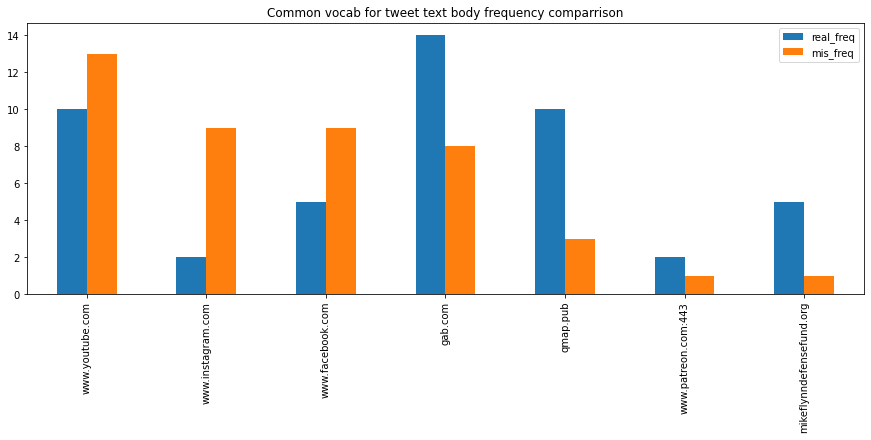

In [129]:
lent = 15
common_df_sort = common_df.sort_values(by=["mis_freq"], ascending = False).head(lent)#.sample(lent)
ax = common_df_sort.plot(title = "Common vocab for tweet text body frequency comparrison" ,kind="bar",figsize=(15,5))
_=ax.set_xticklabels(common_df_sort.word)

Note: The max these links appear in either dataset is 14, which means none of these are very relevant!

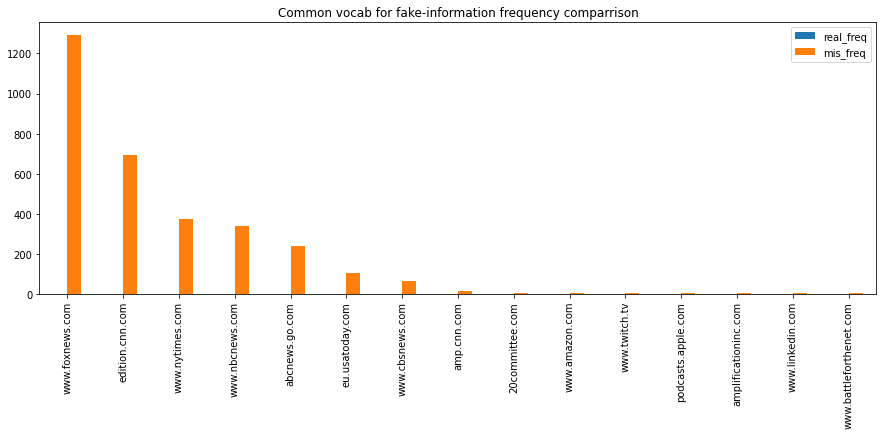

In [130]:
uncommon_mis_table = []

for word in list(uncommon_mis):
    #print(word)
    try:
        uncommon_mis_table.append([word, realinfo_freq[word], misinfo_freq[word] ])
    except:
        uncommon_mis_table.append([word, 0, misinfo_freq[word] ])
        
misinf_uncommon_df = pd.DataFrame(sorted(uncommon_mis_table, key = lambda x: -x[2]), columns = ["word","real_freq","mis_freq"]  ) 

lent = 15
misinf_uncommon_df = misinf_uncommon_df.sort_values(by=["mis_freq"], ascending = False).head(lent)#.sample(lent)
ax = misinf_uncommon_df.plot(title = "Common vocab for fake-information frequency comparrison" ,kind="bar",figsize=(15,5))
_=ax.set_xticklabels(misinf_uncommon_df.word)

In [131]:
misinf_uncommon_df.head(lent)

word  real_freq  mis_freq
0           www.foxnews.com          0      1291
1           edition.cnn.com          0       693
2           www.nytimes.com          0       376
3           www.nbcnews.com          0       339
4            abcnews.go.com          0       241
5           eu.usatoday.com          0       105
6           www.cbsnews.com          0        67
7               amp.cnn.com          0        14
8           20committee.com          0         5
9            www.amazon.com          0         5
10            www.twitch.tv          1         4
11       podcasts.apple.com          0         4
15     amplificationinc.com          0         3
17         www.linkedin.com          0         3
16  www.battleforthenet.com          0         3

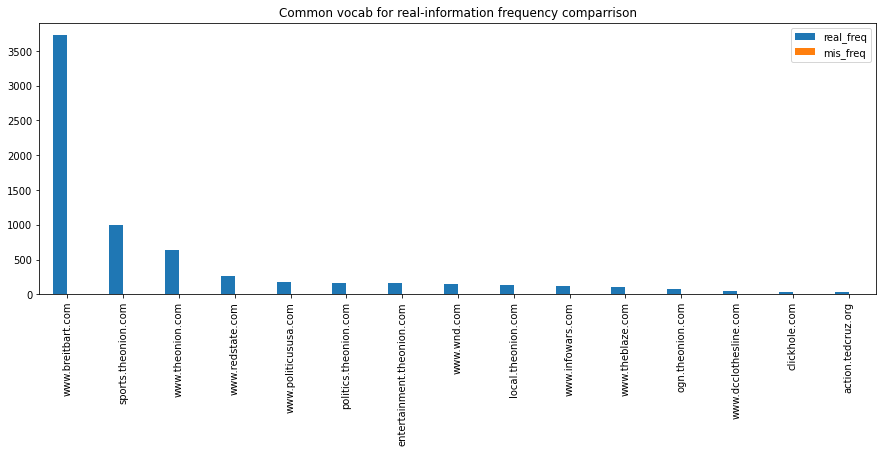

In [132]:
uncommon_real_table = []

for word in list(uncommon_real):
    #print(word)
    try:
        uncommon_real_table.append([word, realinfo_freq[word], misinfo_freq[word] ])
    except:
        uncommon_real_table.append([word, realinfo_freq[word], 0])
        
realinf_uncommon_df = pd.DataFrame(sorted(uncommon_real_table, key = lambda x: -x[2]), columns = ["word","real_freq","mis_freq"]  ) 

lent = 15
realinf_uncommon_df = realinf_uncommon_df.sort_values(by=["real_freq"], ascending = False).head(lent)#.sample(lent)
ax = realinf_uncommon_df.plot(title = "Common vocab for real-information frequency comparrison" , kind="bar",figsize=(15,5))
_=ax.set_xticklabels(realinf_uncommon_df.word)

In [133]:
realinf_uncommon_df.head(lent)

word  real_freq  mis_freq
53           www.breitbart.com       3721         0
7          sports.theonion.com        995         0
38            www.theonion.com        632         0
2             www.redstate.com        265         0
62        www.politicususa.com        172         0
65       politics.theonion.com        169         0
25  entertainment.theonion.com        157         0
73                 www.wnd.com        150         0
39          local.theonion.com        134         0
55            www.infowars.com        123         0
67            www.theblaze.com         98         0
3             ogn.theonion.com         82         0
30       www.dcclothesline.com         45         0
31               clickhole.com         32         0
57          action.tedcruz.org         29         0

Wow! It looks like there is a HUGE correlation between domains linked and mis/real information! Perhaps this is one way that Twitter labelled the dataset!

<a name='Dates' />

### Dates

In [134]:
parser.parse('2009-06-13 04:03:15') 

datetime.datetime(2009, 6, 13, 4, 3, 15)

In [135]:
days= []
now = datetime.now()
dates = data_raw_text["user_account_create"].astype(str)

for c,date in enumerate(dates):  
    try:
        d1 = parser.parse(date)
        days.append((now-d1).days)
    except:
        print(c, date)
        days.append(date)
    

4292 False
6074 86950
13130 False


Looks like we've got a few rows of bad data, lets have a look at them

In [136]:
data_raw_text.iloc[[4292,6074,13130]]

user_name user_account_create user_description text hashtags  label  \
4292         []               False               en  NaN       []    NaN   
6074      False               86950              116   en       []    NaN   
13130        []               False               en  NaN       []    NaN   

       length  word_count   comb  puncs  rt domains  
4292        3           1  nanen      0   0      []  
6074        2           1  en116      0   0      []  
13130       3           1  nanen      0   0      []

These rows are not helpful at all, there's no useful information and no label so lets remove them

In [137]:
data_raw_text[data_raw_text["label"].isna()]

user_name  user_account_create  \
776         SealeTeam1  2012-02-20 00:51:15   
777              False                 9652   
2937        SealeTeam1  2012-02-20 00:51:15   
2938             False                 9653   
4291       stat_butler  2018-04-05 18:59:33   
4292                []                False   
6073   adjunctprofesor  2014-08-07 01:49:58   
6074             False                86950   
13129      stat_butler  2018-04-05 18:59:33   
13130               []                False   

                                        user_description  \
776                                               Oregon   
777                                                   81   
2937                                              Oregon   
2938                                                  81   
4291   A bot that will tweet at the behest of @reinhu...   
4292                                                  en   
6073            Ret. Criminal Justice (CJ) professional.   
6074                                                 116   
13129  A bot that will tweet at the behest of @reinhu...   
13130                                                 en   

                                                    text hashtags  label  \
776                                                  NaN       []    NaN   
777                                                   en       []    NaN   
2937                                                 NaN       []    NaN   
2938                                                  en       []    NaN   
4291   NY Times: Democrats to Broaden Impeachment Inq...       []    NaN   
4292                                                 NaN       []    NaN   
6073                                                 NaN       []    NaN   
6074                                                  en       []    NaN   
13129  NY Times: White House Fires Homeland Security ...       []    NaN   
13130                                                NaN       []    NaN   

       length  word_count                                               comb  \
776         3           1                                          nanOregon   
777         2           1                                               en81   
2937        3           1                                          nanOregon   
2938        2           1                                               en81   
4291       87          12  NY Times: Democrats to Broaden Impeachment Inq...   
4292        3           1                                              nanen   
6073        3           1        nanRet. Criminal Justice (CJ) professional.   
6074        2           1                                              en116   
13129      69          10  NY Times: White House Fires Homeland Security ...   
13130       3           1                                              nanen   

       puncs  rt domains  
776        0   0      []  
777        0   0      []  
2937       0   0      []  
2938       0   0      []  
4291       0   0      []  
4292       0   0      []  
6073       0   0      []  
6074       0   0      []  
13129      0   0      []  
13130      0   0      []

None of these rows will be useful given they have no label so lets remove them all

In [138]:
#create a new column
data_raw_text["days"] = days

In [139]:
data_raw_text = data_raw_text[data_raw_text['label'].notna()]

In [140]:
data_raw_text.reset_index(inplace=True)

In [141]:
data_raw_text["days"].describe()

count     29728
unique     4215
top        1227
freq         75
Name: days, dtype: int64

In [142]:
data_raw_text["days"].max()

5071

In [143]:
data_raw_text["days"].median()

2324.0

In [144]:
data_raw_text["days"].mean()

2334.792182454252

In [145]:
data_raw_text["days"].min()

239

In [146]:
misinformation = data_raw_text[data_raw_text["label"]==1]
realinformation = data_raw_text[data_raw_text["label"]==0]
print(len(misinformation), len(realinformation))
# upsample minority
misinformation = resample(misinformation,
                              replace=True, # sample with replacement
                              n_samples=len(realinformation), # match number in majority class
                              random_state=1) # reproducible results

print(len(misinformation), len(realinformation))

9588 20140
20140 20140


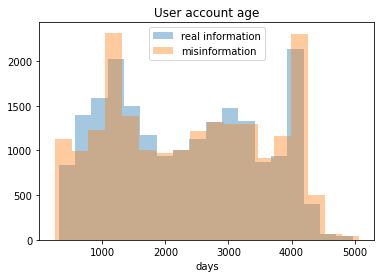

In [147]:
fig, axes = plt.subplots(nrows=1, ncols=1)
ax = sns.distplot( realinformation.days , label = 'real information', bins=18,  kde =False)
ax = sns.distplot( misinformation.days , label = 'misinformation', bins=18, kde =False)
ax.legend()
_=ax.set_title("User account age")

Looks good to me<br>
Now lets make a new category for whether the post was made on a weekend

In [148]:
dates = data_raw[data_raw["label"].notna()]["Tweet_created_at"].astype(str)

weekend = []
for c,date in enumerate(dates):
    try:
        d1 = parser.parse(date)
        if d1.weekday() == 5 or d1.weekday() == 6:
            weekend.append(1)
        else:
            weekend.append(0)
    except:
        print(c, date)
        weekend.append(0)

In [149]:
len(weekend) == len(data_raw_text)

True

Great - and getting rid of all the nan labels solved our date parsing problems

In [150]:
data_raw_text["weekend"] = weekend

In [151]:
ct = pd.crosstab(data_raw_text['weekend'], data_raw_text['label'], 
                 margins=True)
ct

label      0.0   1.0    All
weekend                    
0        16030  7151  23181
1         4110  2437   6547
All      20140  9588  29728

9588 20140
20140 20140


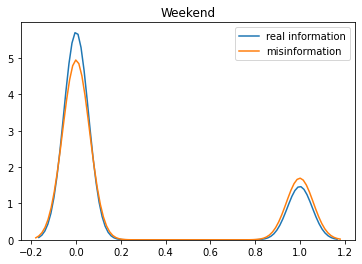

In [152]:
misinformation = data_raw_text[data_raw_text["label"]==1]
realinformation = data_raw_text[data_raw_text["label"]==0]
print(len(misinformation), len(realinformation))
# upsample minority
misinformation = resample(misinformation,
                              replace=True, # sample with replacement
                              n_samples=len(realinformation), # match number in majority class
                              random_state=1) # reproducible results

print(len(misinformation), len(realinformation))

fig, axes = plt.subplots(nrows=1, ncols=1)
ax = sns.kdeplot( realinformation.weekend , label = 'real information')
ax = sns.kdeplot( misinformation.weekend , label = 'misinformation' )
ax.legend()
_=ax.set_title("Weekend")

<a name='TextPreprocessing' />

## Text Preprocessing

In [153]:
texts = data_raw_text["comb"]

In [154]:
texts[0]

'RT @TheOnion: Trump Administration Denies President Was Behind Jared Kushner’s Promotion To 4-Star General https://t.co/ZcLvOuiJYq https://…Kindness. politics.theonion.com trump administration denies president was behind jared 1832993759?utm_content=Main&utm_campaign=SF&utm_source=Twitter&utm_medium=SocialMarketing'

In [155]:
 #from spacy

tick = datetime.now()

stg = []
for i,doc in enumerate(texts):

    mytokens_feature = text_parser(doc)
    mytokens_feature = np.asarray([ word.lower_.strip() for word in mytokens_feature 
                           if word.lower_ not in stopwords 
                            and word.lower_ not in punctuations 
                                and word.lower_[0] != "@" 
                                    and word.lower_[0] != "#" 
                                       and word.lower_[0:2] != "rt" 
                                        and word.lower_[0:6]!="https:"]) 
    mytokens_feature = np.asarray(mytokens_feature)
    feature = re.sub(r'\W+', ' ', " ".join(mytokens_feature) )

    feature= " ".join([w for w in feature.split()
                         if len(w) > 1])

    stg.append(feature)
    
    if i % 100 ==0:
        clear_output(wait=True)
        print(i)
        

#remove non english
stg2=[]
for i,sent in enumerate(stg):
    " ".join(w for w in nltk.wordpunct_tokenize(sent) if w in words) #english words from nltk
    
    if i % 100 ==0:
        clear_output(wait=True)
        print(i)
        
    stg2.append(sent)

tock = datetime.now()    
print("time taken: ",tock - tick) 

29700
time taken:  0:09:09.776190


In [156]:
stg2[100:105]

['one cent www breitbart com clips 2019 06 19 mark levin nt intend pay one damn penny reparations anybody period',
 'jesus christ church blessed married anne priest counselor therapist usn vet corpsman uo alum twitter com theonion status 1115441972905500673',
 'kamala harris elected will take gun dealers licenses away executive action breitbart think proud american maga kag patriot trump israel trump2020 constitution followed gen flynn',
 'trump administration denies president behind jared kushner promotion star general host mma podcast scream void mma pod politics theonion com trump administration denies president behind jared 1832993759 utm_content main utm_campaign sf utm_source twitter utm_medium socialmarketing',
 'white house chief staff literally asked government scientists lie weather absolutely rid outlander fan disney fan loves family dogs']

In [157]:
data_raw_text["processed"] = stg2

In [158]:
data_raw_text.sample(2)

index      user_name  user_account_create  \
17173  17183          La2b4  2009-05-06 15:29:05   
5228    5234  Red_Shirt_no2  2014-05-10 03:59:43   

                                        user_description  \
17173  Register Nurse at Froedtert Hospital Clinical ...   
5228                                  Meme worm. He/him.   

                                                    text  hashtags  label  \
17173  RT @drjkahn: Powerful natural medicine in broc...        []    0.0   
5228   RT @TheOnion: ‘You Know, I Directed It Too,’ B...  [Oscars]    0.0   

       length  word_count                                               comb  \
17173     140          20  RT @drjkahn: Powerful natural medicine in broc...   
5228      140          22  RT @TheOnion: ‘You Know, I Directed It Too,’ B...   

       puncs  rt                       domains  days  weekend  \
17173      0   1                        [t.co]  4044        1   
5228       0   1  [entertainment.theonion.com]  2214        0   

                                               processed  
17173  powerful natural medicine broccoli sprouts fou...  
5228   know directed too bradley cooper says loud one...

We now need to create or document-term matrix which will vectorise all the processed text and ready it for model consumption

In [159]:
min_df_no = 50
max_df_no = 10000 #not using at the moment
docs = data_raw_text["processed"]

tfidf_vec = CountVectorizer( min_df=min_df_no,binary="True", encoding='latin-1', ngram_range=(1,2), stop_words='english')
features_tfidf = tfidf_vec.fit_transform(docs)
feature_frame_count = pd.DataFrame(data = features_tfidf.todense(), columns = tfidf_vec.get_feature_names())

In [160]:
feature_frame_count.sample(2)

000  01  01 04  01 06  01 08  01 13  01 15  01 20  01 23  01 24  ...  \
24096    0   0      0      0      0      0      0      0      0      0  ...   
9176     0   0      0      0      0      0      0      0      0      0  ...   

       yes  york  york times  young  young man  youtube  yrs  zelensky  zion  \
24096    0     0           0      0          0        0    0         0     0   
9176     0     0           0      0          0        0    0         0     0   

       zion williamsons  
24096                 0  
9176                  0  

[2 rows x 3432 columns]

In [161]:
#add the retweet, days and puncs info on and we're ready
feature_frame_count["rt"] = data_raw_text["rt"]
feature_frame_count["days_no"] = data_raw_text["days"]
feature_frame_count["puncs"] = data_raw_text["puncs"]
feature_frame_count["weekend_b"] = data_raw_text["weekend"]

In [162]:
feature_frame_count.sample()

000  01  01 04  01 06  01 08  01 13  01 15  01 20  01 23  01 24  ...  \
23429    0   0      0      0      0      0      0      0      0      0  ...   

       young man  youtube  yrs  zelensky  zion  zion williamsons  rt  days_no  \
23429          0        0    0         0     0                 0   1      937   

       puncs  weekend_b  
23429      0          0  

[1 rows x 3436 columns]

Lets min max scale days & puncs before we concat the data

In [163]:
feature_frame_count["days_no"] -= feature_frame_count["days_no"].min()
feature_frame_count["days_no"] /= feature_frame_count["days_no"].max()
feature_frame_count["days_no"].max()

1.0

In [164]:
feature_frame_count["puncs"] -= feature_frame_count["puncs"].min()
feature_frame_count["puncs"] /= feature_frame_count["puncs"].max()
feature_frame_count["puncs"].max()

1.0

In [165]:
feature_frame_count.sample(5)

000  01  01 04  01 06  01 08  01 13  01 15  01 20  01 23  01 24  ...  \
21282    0   0      0      0      0      0      0      0      0      0  ...   
17648    0   0      0      0      0      0      0      0      0      0  ...   
16044    0   0      0      0      0      0      0      0      0      0  ...   
18363    0   0      0      0      0      0      0      0      0      0  ...   
20135    0   0      0      0      0      0      0      0      0      0  ...   

       young man  youtube  yrs  zelensky  zion  zion williamsons  rt  \
21282          0        0    0         0     0                 0   0   
17648          0        0    0         0     0                 0   0   
16044          0        0    0         0     0                 0   1   
18363          0        0    0         0     0                 0   0   
20135          0        0    0         0     0                 0   1   

         days_no     puncs  weekend_b  
21282   0.720406  0.000000          0  
17648  0.0778146  0.027397          0  
16044   0.638866  0.000000          0  
18363   0.195571  0.000000          1  
20135   0.318295  0.000000          0  

[5 rows x 3436 columns]

### Concat numeric and text features

In [169]:
#double check theyre the same length..
len(feature_frame_count) == len(data_raw_numeric_logged_scaled)#

True

In [170]:
features = pd.concat([feature_frame_count, data_raw_numeric_logged_scaled ],axis=1)

In [171]:
features = features.drop("label", axis=1)

In [172]:
features.sample(3)

000  01  01 04  01 06  01 08  01 13  01 15  01 20  01 23  01 24  ...  \
130      0   0      0      0      0      0      0      0      0      0  ...   
13438    0   0      0      0      0      0      0      0      0      0  ...   
21972    0   0      0      0      0      0      0      0      0      0  ...   

       rt   days_no  puncs  weekend_b  user_followers_count  \
130     1  0.726407    0.0          0              0.253994   
13438   1  0.792632    0.0          0              0.362128   
21972   1  0.653974    0.0          0              0.239367   

       user_friends_count  user_listed_count  user_favourites_count  \
130              0.461093           0.215908               0.643611   
13438            0.377032           0.196178               0.825812   
21972            0.386148           0.000000               0.668592   

       user_statuses_count  Tweet_retweets  
130               0.716084        0.543156  
13438             0.811164        0.609051  
21972             0.676548        0.617457  

[3 rows x 3442 columns]

<a name='FeatureSelection' />

## Feature Selection

Let's do some feature selection from the text features and see if it improves our model accuracy / significantly decreases training time on a basic MLP

First we need to do the test train split and upsample the smaller class

Some functions for our classification metrics & data prep:

In [173]:
def show_history(hist):
    
    #['val_loss', 'val_acc', 'loss', 'acc']
    
    fig = plt.figure()#figsize = (10,5))
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('val vs train accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    fig = plt.figure()#figsize = (10,5))
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('val vs train loss')
    plt.ylabel('error')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    

In [174]:
def acc(y_test, preds):
    pred_df = pd.DataFrame(preds,columns=["pred"])
    y_test_df = pd.DataFrame(y_test).reset_index()
    model_predictions = pd.concat([y_test_df,pred_df],axis=1)
    incorrect_df = model_predictions[model_predictions["label"]!= model_predictions["pred"]]
    print("Model Accuracy: ", 1 - float(len(incorrect_df)/len(model_predictions)))

In [175]:
def conf_mat(y,pred):
    conf_mat = confusion_matrix(y, pred)
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(conf_mat, annot=True, fmt='d',)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [176]:
def roc(y,pred):
    lr_auc = roc_auc_score(y, pred)
    # summarize scores
    print('ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    lr_fpr, lr_tpr, _ = roc_curve(y, pred)
    # plot the roc curve for the model
    plt.plot(lr_fpr, lr_tpr, marker='.', label='roc')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

In [177]:
def report(y,pred):  
    conf_mat(y,pred)
    roc(y,pred)
    print(classification_report(y, pred))

In [178]:
def prep_features(features):
    #pull 0.1 off for test
    X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.1, random_state=1)

    #pull 0.1 off for validate
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)
    #decreases in size by 10%

    # concatenate our training data back together before upsampling
    X = pd.concat([X_train, y_train], axis=1)

    # separate minority and majority classes
    c1 = X[X.label==0]
    c2 = X[X.label==1]
    #print(len(c1), len(c2))

    # upsample minority
    upsampled_c2 = resample(c2,
                              replace=True, # sample with replacement
                              n_samples=len(c1), # match number in majority class
                              random_state=1) # reproducible results

    #print(len(c1),len(upsampled_c2))

    # combine majority and upsampled minority
    upsampled = pd.concat([c1, upsampled_c2])
    X_train = upsampled.sample(frac=1)#.reset_index(drop=True)
    y_train = X_train["label"]
    X_train = X_train.drop("label",axis=1)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [179]:
def build_mlp(X_train, y_train, X_val, y_val, X_test, y_test):
    
    tick = datetime.now()  
    
    #decide hyper parameters: batch_size and epochs
    batch_size = 10
    epochs = 20

    #define how many inputs (num_inputs) and classes (num_classes) there are 
    num_classes = 2
    num_inputs = len(X_train.columns.values)

    # convert label class vectors to binary class matrices [0/1] -> [0 1]/ [1 0]
    train_y = keras.utils.to_categorical(y_train, num_classes)
    validate_y = keras.utils.to_categorical(y_val, num_classes)
    test_y = keras.utils.to_categorical(y_test, num_classes)

    #define model
    model1 = Sequential()
    model1.add(Dense(512, activation='relu', input_shape=(num_inputs,)))
    model1.add(Dropout(0.2))
    model1.add(Dense(512, activation='relu'))
    model1.add(Dropout(0.2))
    model1.add(Dense(num_classes, activation='softmax'))

    #model1.summary()

    #complie model
    model1.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])

    #define early stopping
    early_stopping = EarlyStopping(monitor = "val_acc", patience=3)

    #run model training
    history = model1.fit(X_train, train_y,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0.5,
                        callbacks=[early_stopping],
                        validation_data=(X_val, validate_y))

    #evaluate model
    score = model1.evaluate(X_test, test_y, verbose=0)
    preds = model1.predict(X_test)
    y_pred_bool = np.argmax(preds, axis=1)
    
    tock = datetime.now()    
    print(tock - tick) 
    print("\n")
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print("\n")
    
    return y_pred_bool, history

<a name='Upsampling' />

### Upsampling the smaller class

In [180]:
y = data_raw_numeric["label"]

In [181]:
len(features) == len(y)

True

In [469]:
features.shape

(29728, 3442)

In [459]:
#pull 0.1 off for test
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.1, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((26755, 3442), (2973, 3442), (26755,), (2973,))

In [460]:
#pull 0.1 off for validate
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)
#decreases in size by 10%
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((24079, 3442), (2676, 3442), (24079,), (2676,))

In [461]:
# concatenate our training data back together before upsampling
X = pd.concat([X_train, y_train], axis=1)

In [462]:
tick = datetime.now()
# separate minority and majority classes
c1 = X[X.label==0]
c2 = X[X.label==1]
print(len(c1), len(c2))
# upsample minority
upsampled_c2 = resample(c2,
                          replace=True, # sample with replacement
                          n_samples=len(c1), # match number in majority class
                          random_state=1) # reproducible results

print(len(c1),len(upsampled_c2))

tock = datetime.now()    
print(tock - tick)  

16270 7809
16270 16270
0:00:02.192033


In [463]:
# combine majority and upsampled minority
upsampled = pd.concat([c1, upsampled_c2])
X_train = upsampled.sample(frac=1).reset_index(drop=True)
y_train = X_train["label"]
X_train = X_train.drop("label",axis=1)

In [464]:
len(X_train)

32540

### Control SVM & MLP 

A base-line model with no feature selection to compare our feature selected models to:

In [434]:
y_pred, history = build_mlp(X_train, y_train, X_val, y_val, X_test, y_test)

Train on 32540 samples, validate on 2676 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
0:17:33.164355


Test loss: 0.08231644999020951
Test accuracy: 0.9922637065131377




In [435]:
show_history(history)

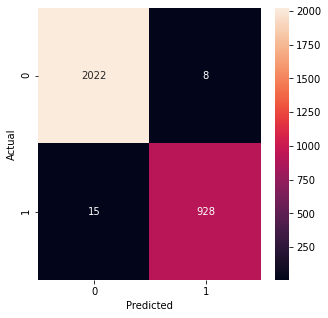

ROC AUC=0.990


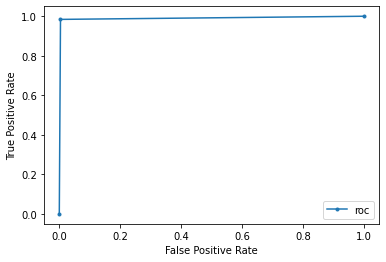

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      2030
         1.0       0.99      0.98      0.99       943

    accuracy                           0.99      2973
   macro avg       0.99      0.99      0.99      2973
weighted avg       0.99      0.99      0.99      2973



In [436]:
report(y_test,y_pred)

<br>And an SVM baseline model:

In [465]:
tick = datetime.now()  

model_svc = LinearSVC()
model_svc.fit(X_train, y_train)
y_pred = model_svc.predict(X_test)

tock = datetime.now()    
print(tock - tick) 

0:00:12.818914


ROC AUC=0.986


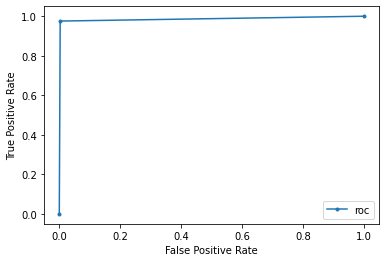

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      2030
         1.0       0.99      0.98      0.98       943

    accuracy                           0.99      2973
   macro avg       0.99      0.99      0.99      2973
weighted avg       0.99      0.99      0.99      2973



In [466]:
report(y_test,y_pred)

In [467]:
pred_df = pd.DataFrame(y_pred,columns=["pred"])
y_test_df = pd.DataFrame(y_test).reset_index()
model_predictions = pd.concat([y_test_df,pred_df],axis=1)
incorrect_df = model_predictions[model_predictions["label"]!= model_predictions["pred"]]
1 - float(len(incorrect_df)/len(model_predictions))

0.9902455432223344

Wow! a 99% accuracy without doing any feature selection or hyperparameter tuning

For feature selection to be worth it, it must outperform these baseline models (with no feature selection)

<a name='Chi-Square' />

### Chi-Squre test

We'll just do it on the doc term matrix as most of the other features we've engineered are non-categoric, also, from our previous analysis we are pretty sure they correlate with the label

In [390]:
feature_frame_count_c2 = feature_frame_count.iloc[:,0:3432] #number of cols in the doc term matrix

In [391]:
len(feature_frame_count_c2.columns)

3432

In [392]:
feature_frame_count_c2.sample()

000  01  01 04  01 06  01 08  01 13  01 15  01 20  01 23  01 24  ...  \
19848    0   0      0      0      0      0      0      0      0      0  ...   

       yes  york  york times  young  young man  youtube  yrs  zelensky  zion  \
19848    0     0           0      0          0        0    0         0     0   

       zion williamsons  
19848                 0  

[1 rows x 3432 columns]

In [393]:
ct = pd.crosstab(feature_frame_count_c2['trump'], y, 
                 margins=True)
ct

label    0.0   1.0    All
trump                    
0      15730  5425  21155
1       4410  4163   8573
All    20140  9588  29728

In [394]:
ct = pd.crosstab(feature_frame_count_c2['maga'], y, 
                 margins=True)
ct

label    0.0   1.0    All
maga                     
0      16259  8763  25022
1       3881   825   4706
All    20140  9588  29728

In [395]:
tick = datetime.now()
X_new_c2 = SelectKBest(chi2, k=3000).fit_transform(feature_frame_count_c2, y)
tock = datetime.now()    
print(tock - tick)  

0:00:01.098994


Now we'll add the other features back in and re train the model

In [396]:
X_new_c2 = pd.DataFrame(X_new_c2)

In [397]:
X_new_c2.sample()

0     1     2     3     4     5     6     7     8     9     ...  2990  \
11659     0     0     0     0     0     0     0     0     0     0  ...     0   

       2991  2992  2993  2994  2995  2996  2997  2998  2999  
11659     0     0     0     0     0     0     0     0     0  

[1 rows x 3000 columns]

In [398]:
X_new_c2 = pd.DataFrame(X_new_c2)
features_c2 = pd.concat( 
    
    #concat X_new, with the extra four columns from feature_frame_count that we took out earlier
    [X_new_c2, feature_frame_count.iloc[:,len(feature_frame_count_c2.columns): len(feature_frame_count.columns)]
     
    ], axis = 1)

In [399]:
len(data_raw_numeric_logged_scaled) == len(features_c2)

True

In [400]:
#add the numeric features back on
features_c2 = pd.concat( 
    
    #concat X_new, with the extra four columns from feature_frame_count that we took out earlier
    [features_c2, data_raw_numeric_logged_scaled.iloc[:,0:-1] ] #skip label
     
    , axis = 1)

In [401]:
features_c2.sample()

0  1  2  3  4  5  6  7  8  9  ...  rt   days_no  puncs  weekend_b  \
8446  0  1  0  0  1  0  0  0  0  0  ...   1  0.748965    0.0          1   

      user_followers_count  user_friends_count  user_listed_count  \
8446              0.224149            0.367979                0.0   

      user_favourites_count  user_statuses_count  Tweet_retweets  
8446               0.582626             0.517661        0.832042  

[1 rows x 3010 columns]

Now let's use this process to perform Chi-Square using different numbers of features extracted ranging from 1000 to 3000

In [402]:
feature_nos = [1000,1500,2000,2500,3000]

ROC_scores = []

c2_preds = []

for i in feature_nos:
    print("-----------------")
    #print(i)
    
    #select best from doc term matrix
    X_new_c2 = pd.DataFrame(SelectKBest(chi2, k=i).fit_transform(feature_frame_count_c2, y))
    
    #concat other features
    features_c2 = pd.concat( 
        [X_new_c2, feature_frame_count.iloc[:,len(feature_frame_count_c2.columns): len(feature_frame_count.columns)]
            ], axis = 1)
    
    features_c2 = pd.concat( 
        [features_c2, data_raw_numeric_logged_scaled.iloc[:,0:-1] 
            ], axis = 1)
    
    #test train & upsample
    X_train, y_train, X_val, y_val, X_test, y_test = prep_features(features_c2)
    
    #train SVC
    model_svc = LinearSVC()
    model_svc.fit(X_train, y_train)
    y_pred = model_svc.predict(X_test)
    
    lr_auc = roc_auc_score(y_test, y_pred)
    print("Features", i, " ROC AUC =" ,lr_auc)
    ROC_scores.append(lr_auc)
    c2_preds.append(y_pred)

-----------------
Features 1000  ROC AUC = 0.9722876366694702
-----------------
Features 1500  ROC AUC = 0.9853211895794263
-----------------
Features 2000  ROC AUC = 0.9871205512226465
-----------------
Features 2500  ROC AUC = 0.987007715654368
-----------------
Features 3000  ROC AUC = 0.9866485746673702


In [403]:
plt.plot(feature_nos, ROC_scores, marker='x', label='AUC')
plt.xlabel('Number of features')
plt.ylabel('ROC AUC')
plt.legend()
plt.show()

Our peak result was extracting 2000 features

In [449]:
report(y_test, c2_preds[2])

ROC AUC=0.987


              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2030
         1.0       0.98      0.98      0.98       943

    accuracy                           0.99      2973
   macro avg       0.99      0.99      0.99      2973
weighted avg       0.99      0.99      0.99      2973



In [471]:
for i in range(len(c2_preds)) :  
    pred_df = pd.DataFrame(c2_preds[i],columns=["pred"])
    y_test_df = pd.DataFrame(y_test).reset_index()
    model_predictions = pd.concat([y_test_df,pred_df],axis=1)
    incorrect_df = model_predictions[model_predictions["label"]!= model_predictions["pred"]]
    print(i, 1 - float(len(incorrect_df)/len(model_predictions)))    

0 0.9710729902455433
1 0.9865455768583922
2 0.9882273797510932
3 0.9892364614867137
4 0.9899091826437941


This didnt outperform our baseline MLP model showing that msot of the features in the doc term matrix are useful for classification

<a name='PCA' />

### PCA

We'll perform the same test with PCA

In [345]:
feature_frame_count_pca = feature_frame_count_c2

In [406]:
feature_nos = [1000,1500,2000,2500,3000]
ROC_scores = []
PCA_preds = []

for numDimensions in feature_nos:
    print("-----------------")
    #print(i)
    
    #perform PCA
    docTermMat = np.transpose(np.asarray(feature_frame_count_pca))

    #linear algebra doc term -> lower dimensional space
    u, s, vt = np.linalg.svd(docTermMat, full_matrices=False)
    u = u[:, :numDimensions]
    sigma = np.diag(s)[:numDimensions, :numDimensions]
    #our new lower dimensional version of the docTermMatrix
    vt = vt[:numDimensions, :]

    df_lsa = pd.DataFrame(vt.T,columns=["t"+str(i) for i in range(numDimensions) ])
    #df_lsa["doc"] = text_features["processed"]
    #rearrange cols
    cols = df_lsa.columns.tolist()
    cols = cols[-1:] + cols[:-1]

    #new X_new
    X_new_PCA = df_lsa[cols]    
    
    #concat other features
    features_PCA = pd.concat( 
        [X_new_PCA, feature_frame_count.iloc[:,len(feature_frame_count_pca.columns): len(feature_frame_count.columns)]
            ], axis = 1)
    
    features_PCA= pd.concat( 
        [features_PCA, data_raw_numeric_logged_scaled.iloc[:,0:-1] 
            ], axis = 1)
    
    #test train & upsample
    X_train, y_train, X_val, y_val, X_test, y_test = prep_features(features_PCA)
    
    #train SVC
    model_svc = LinearSVC()
    model_svc.fit(X_train, y_train)
    y_pred = model_svc.predict(X_test)
    
    lr_auc = roc_auc_score(y_test, y_pred)
    print("Features", numDimensions, " ROC AUC =" ,lr_auc)
    ROC_scores.append(lr_auc)
    PCA_preds.append(y_pred)

-----------------
Features 1000  ROC AUC = 0.9728215160712328
-----------------
Features 1500  ROC AUC = 0.9756060993893296
-----------------
Features 2000  ROC AUC = 0.9788456816887723
-----------------
Features 2500  ROC AUC = 0.9812504897377095
-----------------
Features 3000  ROC AUC = 0.9768376264829257


In [354]:
X_train, y_train, X_val, y_val, X_test, y_test = prep_features(features_pca)
y_preds, history_pca = build_mlp(X_train, y_train, X_val, y_val, X_test, y_test)

Train on 32540 samples, validate on 2676 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
0:16:54.184896


Test loss: 0.21044432631507656
Test accuracy: 0.977127480879802




In [407]:
plt.plot(feature_nos, ROC_scores, marker='x', label='AUC')
plt.xlabel('Number of features')
plt.ylabel('ROC AUC')
plt.legend()
plt.show()

Lets have a look at our best performing model, 2500 features

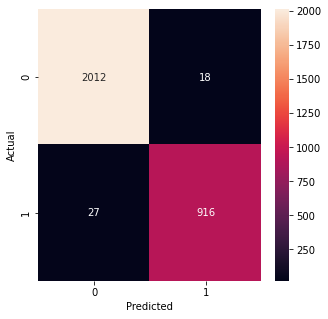

ROC AUC=0.981


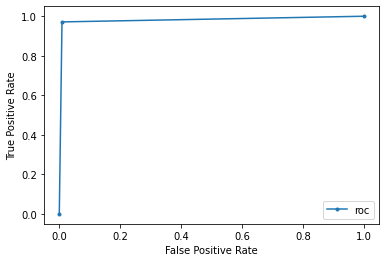

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2030
         1.0       0.98      0.97      0.98       943

    accuracy                           0.98      2973
   macro avg       0.98      0.98      0.98      2973
weighted avg       0.98      0.98      0.98      2973



In [409]:
report(y_test, PCA_preds[3])

The accuracy has decreased here with no training time increase, so we wont use PCA

### Feature selection conclusion

None of the models outperformed our baseline MLP so we wont do any feature extraction

In [182]:
X_train, y_train, X_val, y_val, X_test, y_test = prep_features(features)

<a name='ModelSelection' />

## Model Selection

<a name='MLP' />

### MLP

<a name='Keras' />

### Keras

In [440]:
y_pred, history = build_mlp(X_train, y_train, X_val, y_val, X_test, y_test)

Train on 32540 samples, validate on 2676 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
0:21:40.308386


Test loss: 0.07681639818061446
Test accuracy: 0.9929364276702181




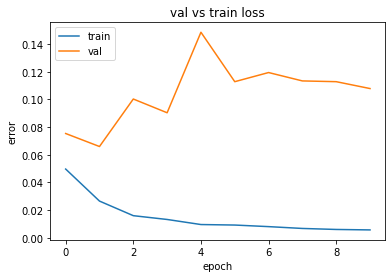

In [441]:
show_history(history)

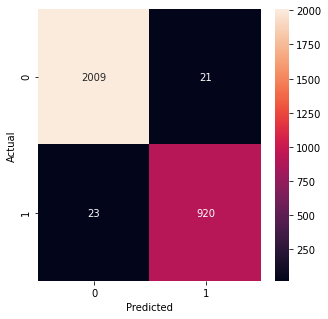

ROC AUC=0.983


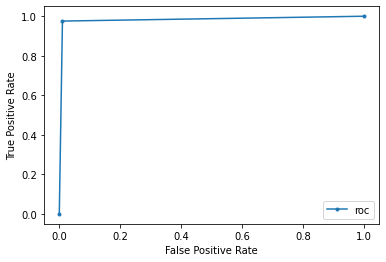

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2030
         1.0       0.98      0.98      0.98       943

    accuracy                           0.99      2973
   macro avg       0.98      0.98      0.98      2973
weighted avg       0.99      0.99      0.99      2973



In [442]:
report(y_test, y_preds)

<a name='Sci-kitLearn' />

### Sci-kit

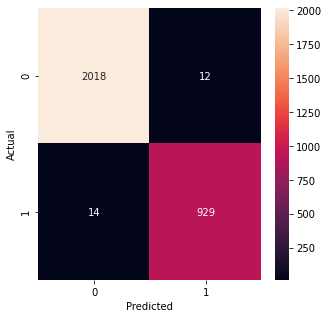

ROC AUC=0.990


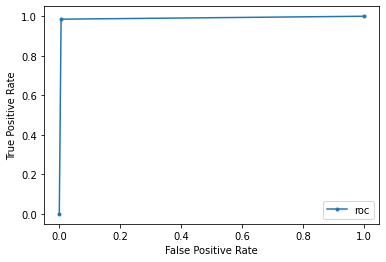

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2030
         1.0       0.99      0.99      0.99       943

    accuracy                           0.99      2973
   macro avg       0.99      0.99      0.99      2973
weighted avg       0.99      0.99      0.99      2973



In [473]:
mlp = MLPClassifier(max_iter=100)
mlp.fit(X_train, y_train)
y_preds = mlp.predict(X_test)
report(y_test,y_preds)

In [475]:
acc(y_test,y_preds)

Model Accuracy:  0.9912546249579549


<a name='SVM' />

### Support Vector Machine

In [476]:
tick = datetime.now()  

model_svc = LinearSVC()
model_svc.fit(X_train, y_train)
y_pred = model_svc.predict(X_test)

tock = datetime.now()    
print(tock - tick) 

0:00:14.305649


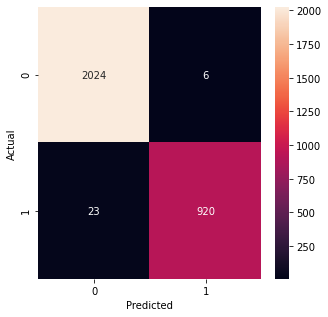

ROC AUC=0.986


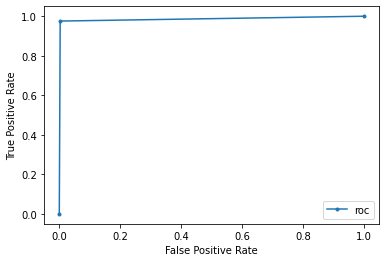

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      2030
         1.0       0.99      0.98      0.98       943

    accuracy                           0.99      2973
   macro avg       0.99      0.99      0.99      2973
weighted avg       0.99      0.99      0.99      2973



In [477]:
report(y_test, y_pred)

In [480]:
acc(y_test,y_pred)

Model Accuracy:  0.9902455432223344


<a name='DecisionTree' />

### Decision Tree

0:00:26.262376


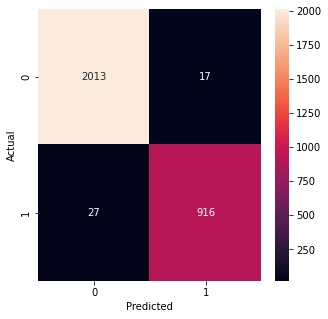

ROC AUC=0.981


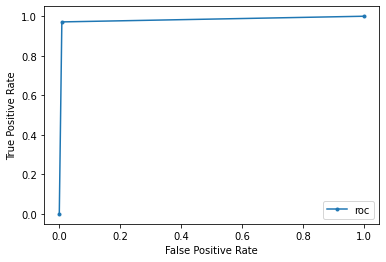

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2030
         1.0       0.98      0.97      0.98       943

    accuracy                           0.99      2973
   macro avg       0.98      0.98      0.98      2973
weighted avg       0.99      0.99      0.99      2973



In [481]:
# Make a decision tree and train
tick = datetime.now()

tree = DecisionTreeClassifier(random_state=1)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

tock = datetime.now()    
print(tock - tick) 

report(y_test, y_pred)

In [482]:
acc(y_test,y_pred)

Model Accuracy:  0.9852001345442314


<a name='RandomForest' />

### Random Forest

0:00:51.354818


ROC AUC=0.991


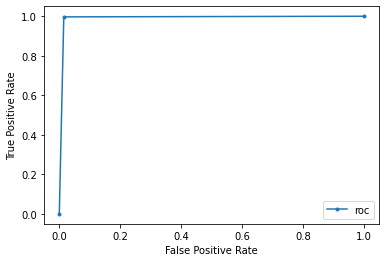

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      2030
         1.0       0.97      1.00      0.98       943

    accuracy                           0.99      2973
   macro avg       0.98      0.99      0.99      2973
weighted avg       0.99      0.99      0.99      2973

Model Accuracy:  0.9889001009081736


In [483]:
tick = datetime.now() 
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
# Fit on training data
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

tock = datetime.now()    
print(tock - tick) 

report(y_test, y_pred)

acc(y_test,y_pred)

<a name='Hyperparameter' />

## Hyper Parameter tuning (with GridSearch)

Lets do some tuning on the best couple of models to see if we can improve them

<a name='SVM2' />

### SVM Gaussian

In [184]:
tick = datetime.now()  

model_svc = SVC(kernel="rbf",gamma="auto")
model_svc.fit(X_train, y_train)
y_pred = model_svc.predict(X_test)

tock = datetime.now()    
print(tock - tick) 

0:41:11.211727


In [185]:
acc(y_test, y_pred)

Model Accuracy:  0.937773292970064


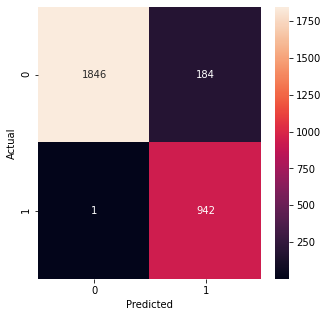

ROC AUC=0.954


              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95      2030
         1.0       0.84      1.00      0.91       943

    accuracy                           0.94      2973
   macro avg       0.92      0.95      0.93      2973
weighted avg       0.95      0.94      0.94      2973



In [186]:
report(y_test, y_pred)

### SVM 

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.5min finished


{'C': 1}
0:01:44.023669


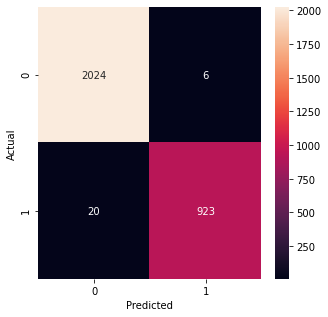

ROC AUC=0.988


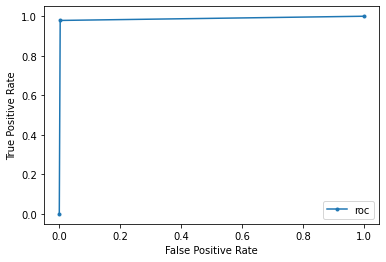

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      2030
         1.0       0.99      0.98      0.99       943

    accuracy                           0.99      2973
   macro avg       0.99      0.99      0.99      2973
weighted avg       0.99      0.99      0.99      2973

Model Accuracy:  0.9912546249579549


In [190]:
tick = datetime.now()   

param_grid={ 
    'C':[0.1,1,10] ,  
    #'dual':[False,True]   
}
grid = GridSearchCV(LinearSVC(dual = False, max_iter = 10000, fit_intercept=True  ),param_grid,verbose=1,cv=3)

grid.fit(X_train,y_train)
grid_predictions = grid.predict(X_test)
print(grid.best_params_)

tock = datetime.now()    
print(tock - tick)

report(y_test,grid_predictions)
acc(y_test,grid_predictions)

<a name='MLP2' />

### MLP 

In [620]:
X_train, y_train, X_val, y_val, X_test, y_test = prep_features(features)

16270 7809
16270 16270


Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  48 tasks      | elapsed: 56.7min
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed: 293.8min
[Parallel(n_jobs=4)]: Done 480 out of 480 | elapsed: 700.5min finished


11:42:55.212832
Best parameters found:
 {'activation': 'relu', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.996 (+/-0.002) for {'activation': 'tanh', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
0.996 (+/-0.002) for {'activation': 'tanh', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.996 (+/-0.003) for {'activation': 'tanh', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.996 (+/-0.002) for {'activation': 'tanh', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.996 (+/-0.002) for {'activation': 'tanh', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 

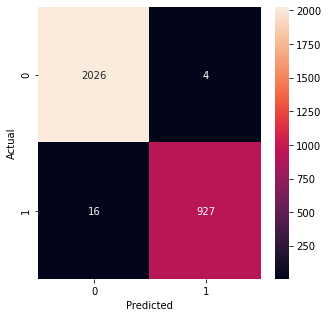

ROC AUC=0.991


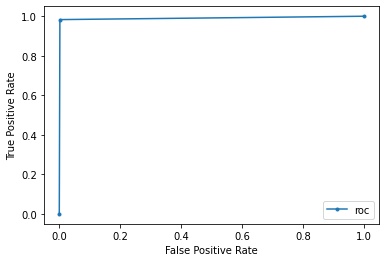

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      2030
         1.0       1.00      0.98      0.99       943

    accuracy                           0.99      2973
   macro avg       0.99      0.99      0.99      2973
weighted avg       0.99      0.99      0.99      2973



In [623]:
tick = datetime.now() 

mlp = MLPClassifier(max_iter=1000)




parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
    "early_stopping":[False,True]
}
grid = GridSearchCV(mlp, parameter_space, n_jobs=4, cv=5,verbose=0.5)
grid.fit(X_train, y_train)

tock = datetime.now()    
print(tock - tick)

# Best paramete set
print('Best parameters found:\n', grid.best_params_)

# All results
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

#and finally report
grid_pred = grid.predict(X_test)
report(y_test,grid_pred)

In [ ]:
best_params = {'activation': 'relu', 'alpha': 0.05, 
               'early_stopping': False, 'hidden_layer_sizes': (50, 50, 50), 
               'learning_rate': 'constant', 'solver': 'adam'}

<a name='FalsePositive' />

### False Positive/ Negative Analysis

Looks like we aren't going to get much higher accuracy than this

In [630]:
print(grid.best_params_)

{'activation': 'relu', 'alpha': 0.05, 'early_stopping': False, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}


In [624]:
pred_df = pd.DataFrame(grid_pred,columns=["pred"])
y_test_df = pd.DataFrame(y_test).reset_index()
model_predictions = pd.concat([y_test_df,pred_df],axis=1)

In [625]:
model_predictions 

index  label  pred
0     27648    0.0   0.0
1      4925    1.0   1.0
2      5163    0.0   0.0
3     29699    0.0   0.0
4     21728    0.0   0.0
...     ...    ...   ...
2968   1320    0.0   0.0
2969   1385    0.0   0.0
2970  19441    1.0   1.0
2971  14418    1.0   1.0
2972  14286    1.0   1.0

[2973 rows x 3 columns]

Lets look at the rows in which they dont agree

In [626]:
incorrect_df = model_predictions[model_predictions["label"]!= model_predictions["pred"]]
incorrect_df

index  label  pred
61     5623    1.0   0.0
123   27299    1.0   0.0
193   16444    1.0   0.0
207   25359    1.0   0.0
234   12892    0.0   1.0
623    3203    0.0   1.0
765   20221    1.0   0.0
1035   9170    1.0   0.0
1040  14051    1.0   0.0
1180  22168    1.0   0.0
1274   5344    1.0   0.0
1471  21674    1.0   0.0
1551  20414    1.0   0.0
1559   5820    1.0   0.0
1775  25344    0.0   1.0
2258  15199    0.0   1.0
2610  15682    1.0   0.0
2636   6808    1.0   0.0
2893  10204    1.0   0.0
2945   1901    1.0   0.0

Accuracy of model:

In [636]:
1 - float(len(incorrect_df)/len(model_predictions))

0.9932727884291961

Our false positives are where the model predicted 1 (mis information) and it was actually real information

As our test train split was pulled from the "features" dataframe, which was pulled from the "data_raw_text" so we can refer back to this as these are the indexs our test data knows

In [627]:
#false positives: the model predicted it was misinformation but it wasnt - pred 1 actual 0
#false negatives: the model predicted that it was real information but it wasnt - pred 0 - actual 1

fp = []
fn = []

for i in incorrect_df.iterrows():
    
    indx = i[1][0]
    actual = i[1][1]
    pred = i[1][2]
    
    if pred > actual:
        fp.append(indx)
    else:
        fn.append(indx)

In [628]:
#lets look at false positives - the model thought these were fake news but they werent
for i in fp:
    print(data_raw_text["comb"][i] + "\n")

@afisims's account is temporarily unavailable because it violates the Twitter Media Policy. Learn more.@afisims's account is temporarily unavailable because it violates the Twitter Media Policy. Learn more.

RT @RRosendary: Finally!
Real women in this country have been disrespected by allowing these men to compete with BIOLOGICALLY grown women.…#MAGA #DrainTheSwamp #TrumpTrain @THEHermanCain @GenFlynn follows.

RT @Thewiseonewon: Eric Swalwell Pushes Licensing, Insurance Requirements for Gun Owners

 @ericswalwell is crazy!  Am I right??  https://t…Air Force  Veteran. Joined to follow Trump,  stayed to fight with him. t…Air

RT @woodman5427: I am glad that Sport are finally realizing that this Men are Men no matter what they want to say they are. I want to be a…#PRESIDENT TRUMP #CANADA DRAIN THE SWAMP #CANADIAN TRUMP #MSM CORRUPTION #DUMP TRUDEAU



In [629]:
#lets look at false negatives - the model thought these were real news but they werent 
for i in fn:
    print(data_raw_text["comb"][i] + "\n")

RT @kylegriffin1: As Netanyahu refuses to concede, NBC First Read notes: "It's striking that what's playing out after Israel's election yes…Last of the Real Ones| Daily Live Streams https://t.co/v1NS0EbzCH #gamer #Bernie2020 #positivevibes #nerd #catperson #LegendaryLegend #productofagreatmom www.twitch.tv woke_legend

RT @steinhauserNH1: 2020 Watch: @AndrewYang tells @foxnewspolitics his "small army of very, very, smart lawyers” assures him his #FreedomDi…Husband, father, coach, golfer. #YangGang All things @AndrewYang Caps, Nats.

RT @psychdr100: Trump defends the gun industry's ability to sell assault rifles: Helps cause mass shootings.

And then there is his defense…Amazing wife.Proud father of 2, a fantastic daughter inlaw and two awesome Grandchildren.  Love is the answer , All  humans are in this together.

RT @drogon_dracarys: @ryangrim NYT confirms the call or calls discussing Khashoggi were placed in this highly classified computer system ht…#TeamBaker ! #neverTrump; bi-parti